## CASA0002 Urban Simulation: Assessment
---

This code is for the assessment of UCL course Urban Simulation.

### import libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf

# Part 1: London's underground resilience

## I. Topological network

In this part, you will evaluate the resilience of the London’s underground through the removal of stations that can potentially make the underground vulnerable. Through the procedure outlined below you will investigate which are the stations that are most critical for the functioning of the underground, and which methodology is more appropriate to finding these stations.

### Constructing the network

generated from practical 10

#### load london underground shapefile data

In [2]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

In [3]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

In [4]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           529 non-null    object  
 1   name         529 non-null    object  
 2   nlc_id       518 non-null    object  
 3   lines        529 non-null    object  
 4   cartography  529 non-null    object  
 5   altmodeid    16 non-null     object  
 6   alt_id       337 non-null    object  
 7   altmodeid2   2 non-null      object  
 8   zone         529 non-null    object  
 9   geometry     529 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 41.5+ KB


In [5]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        701 non-null    object  
 1   lines     701 non-null    object  
 2   geometry  701 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 16.6+ KB


#### station file cleaning

In [6]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [7]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [8]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [9]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

#### line file cleaning

In [10]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))

#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [11]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

Central


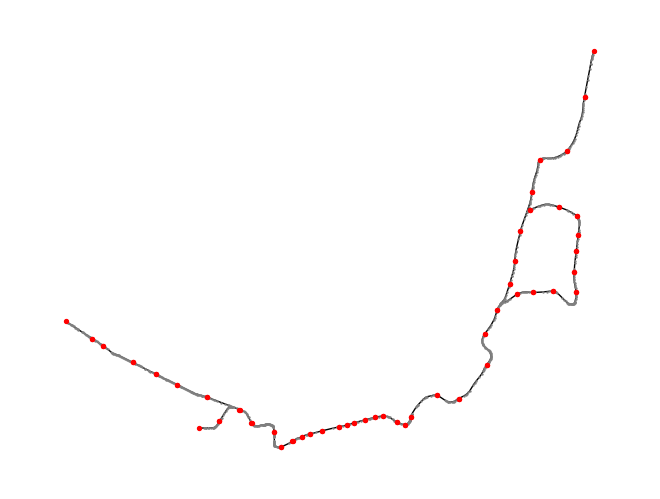

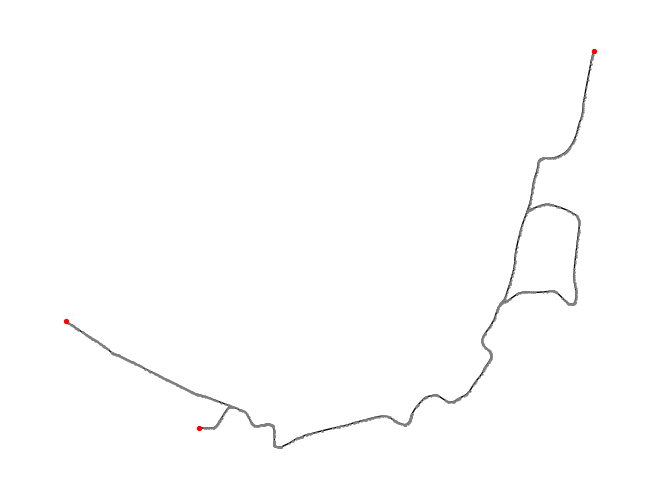

1
DLR


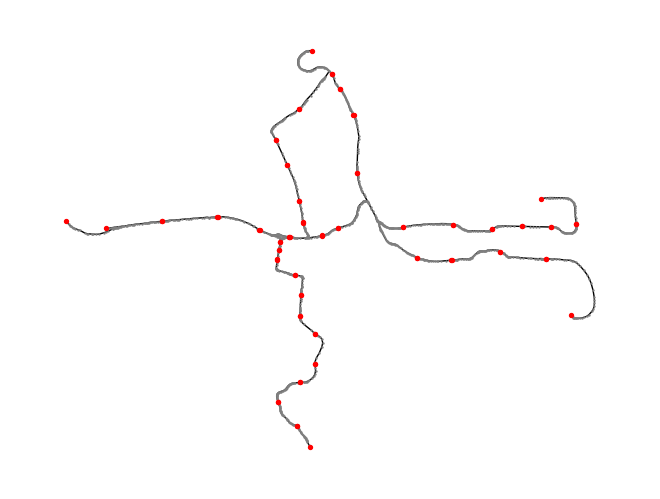

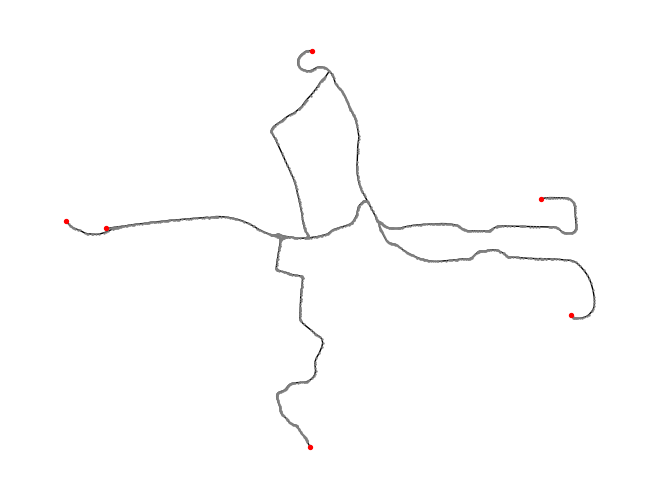

1
Metropolitan


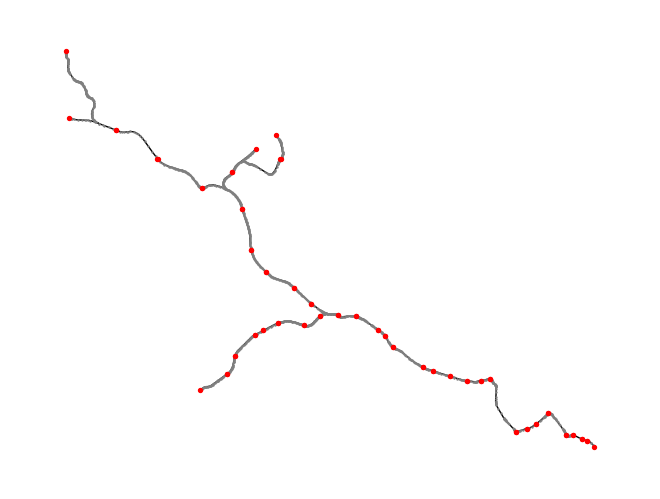

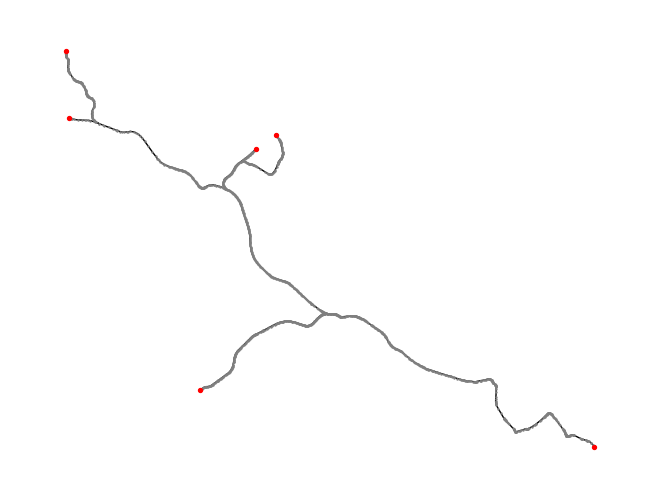

1
Northern


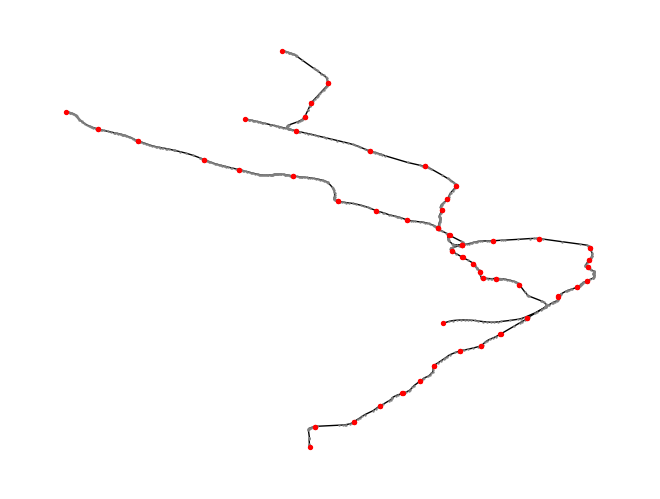

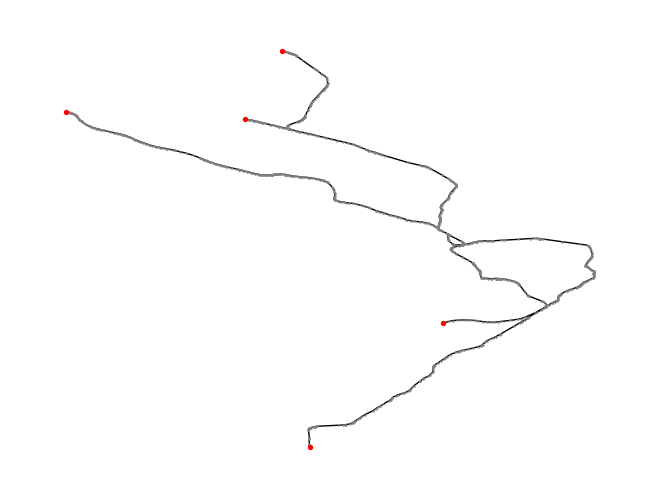

1
TfL Rail


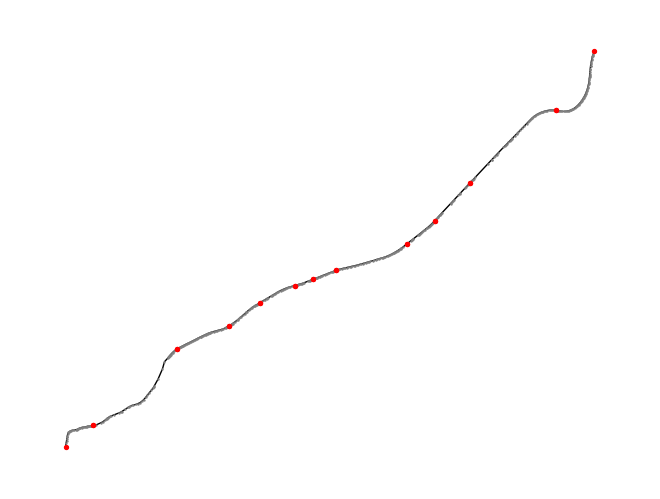

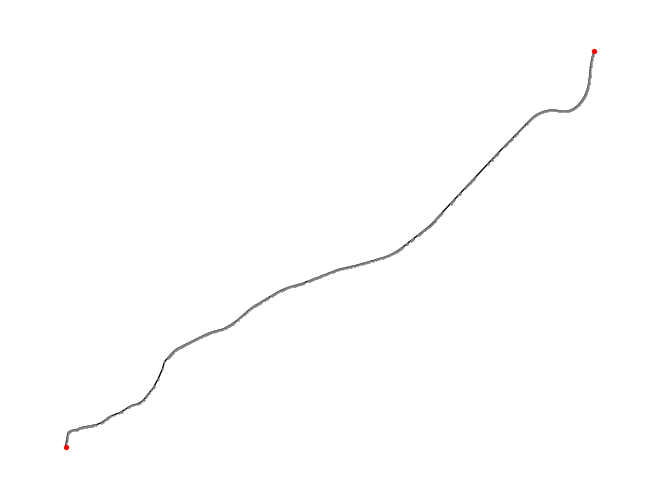

1
London Overground


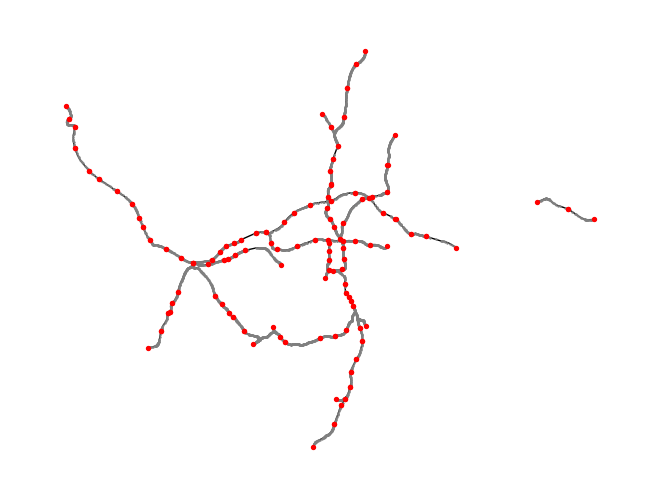

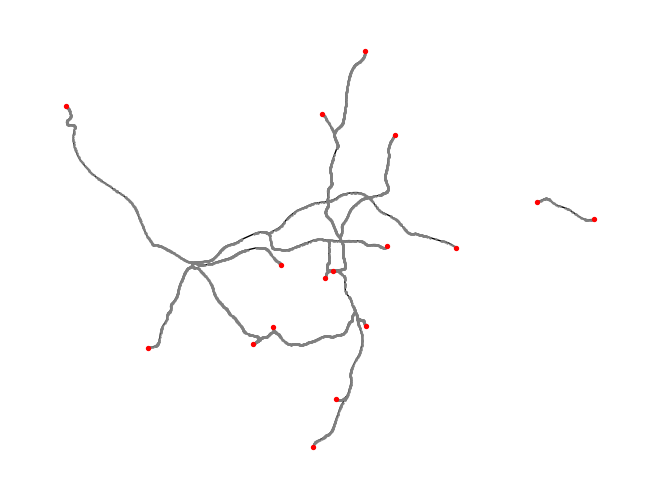

3
Piccadilly


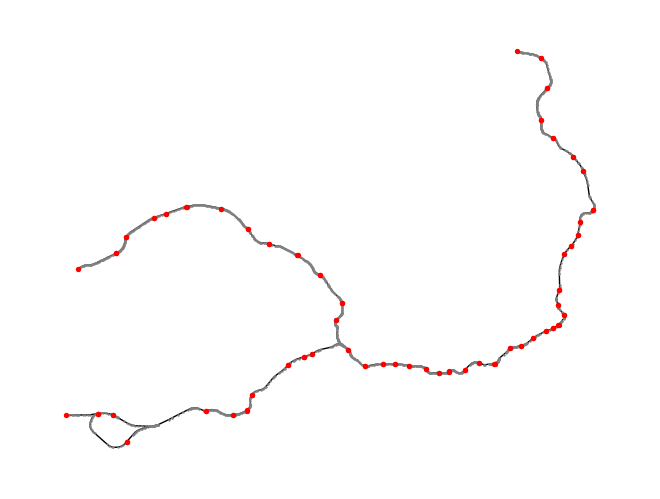

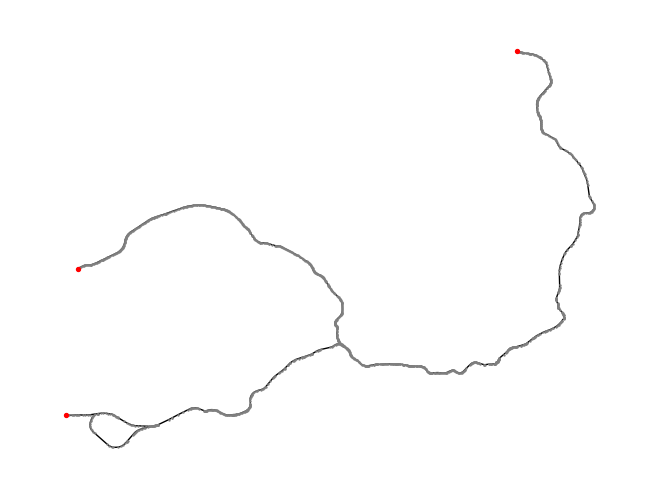

1
District


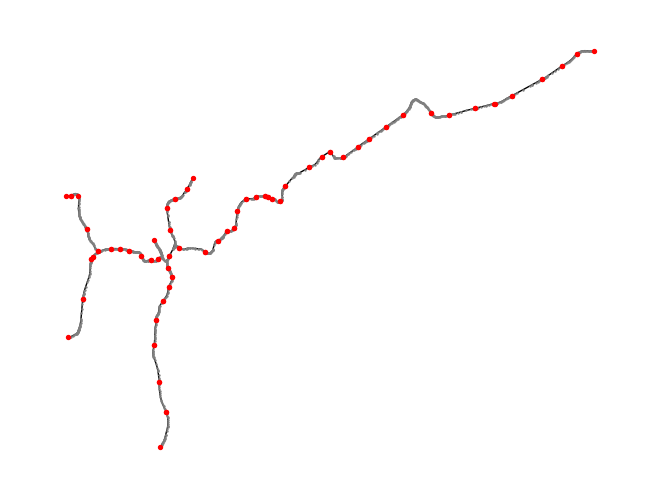

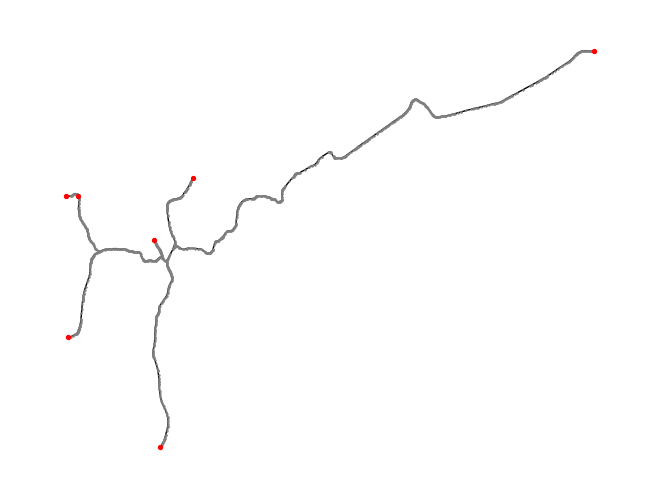

1
Victoria


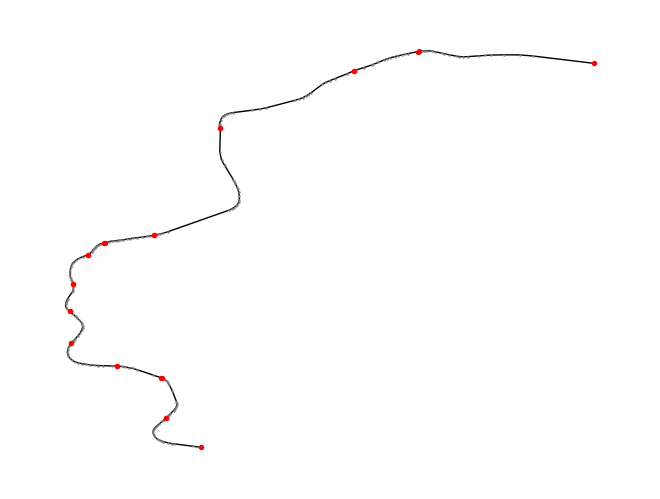

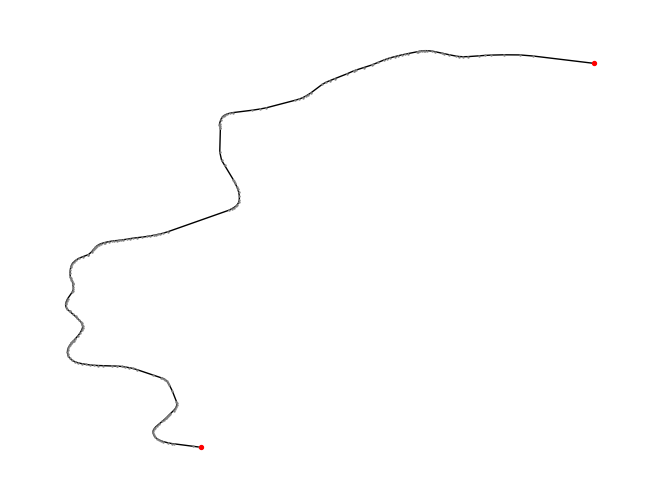

1
Jubilee


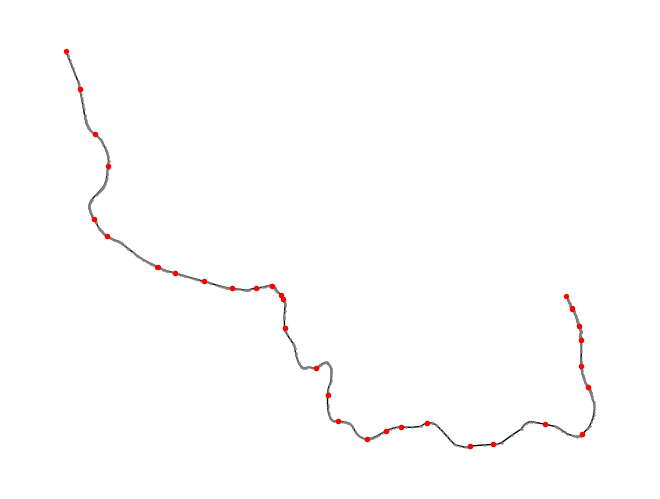

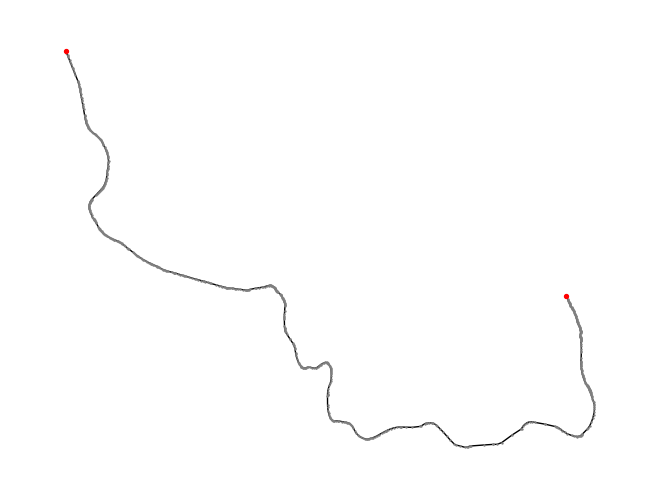

1
Hammersmith & City


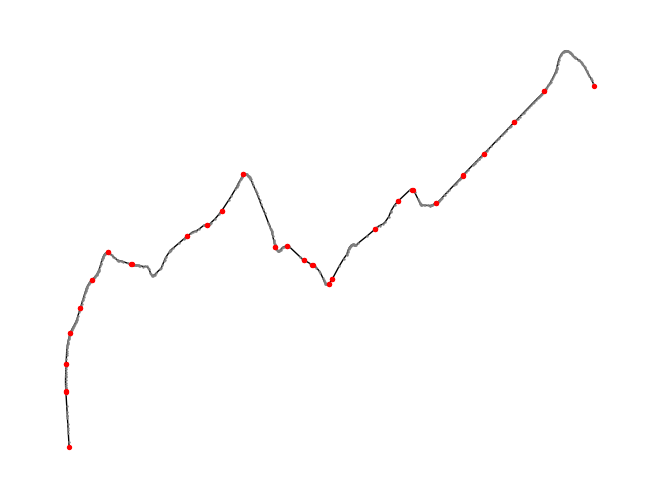

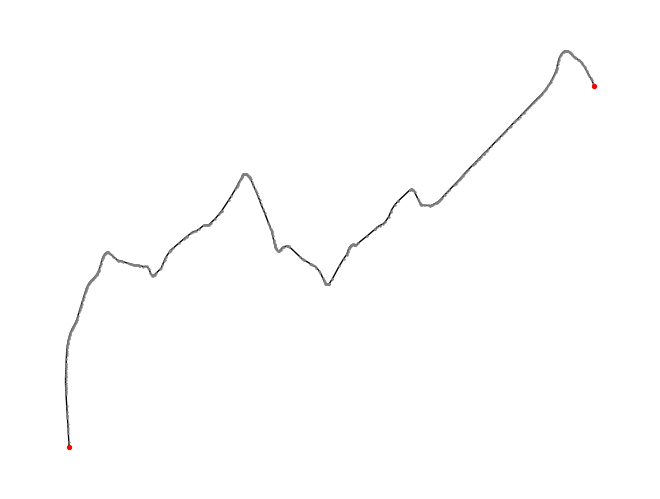

1
Waterloo & City


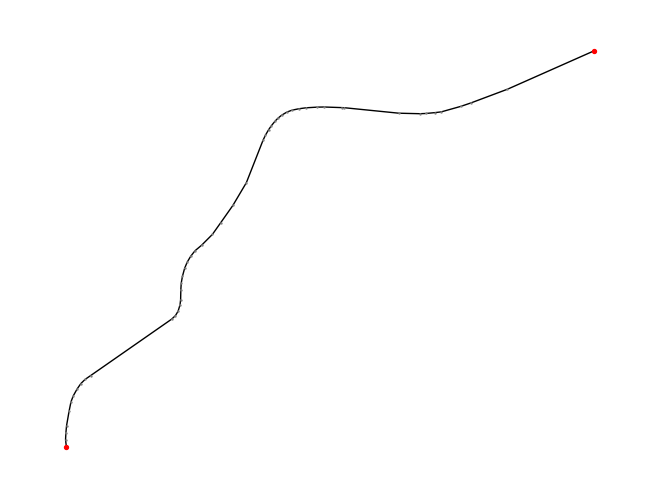

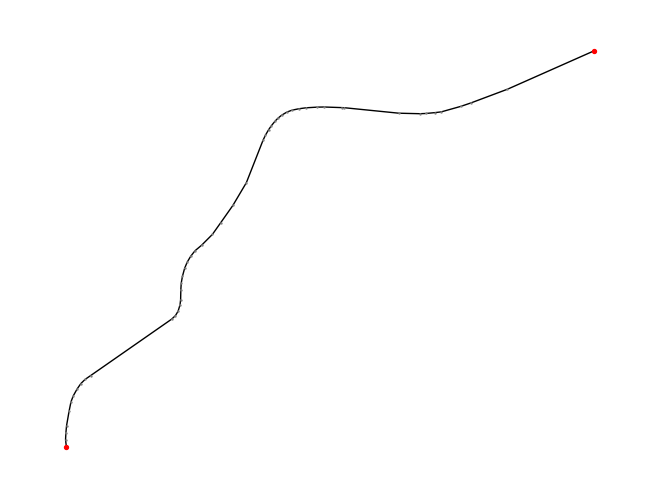

1
Bakerloo


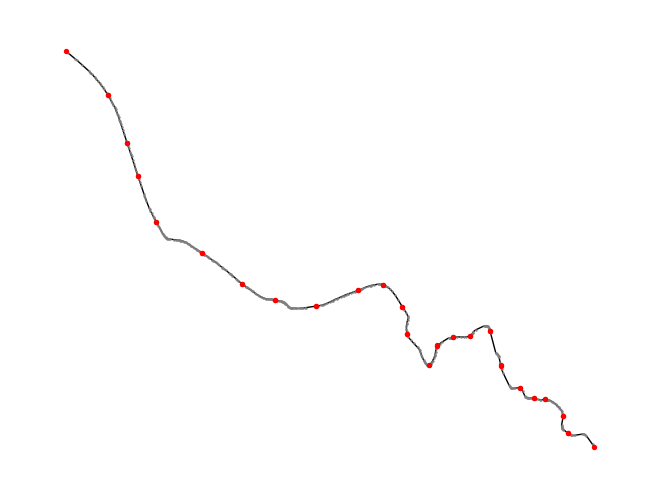

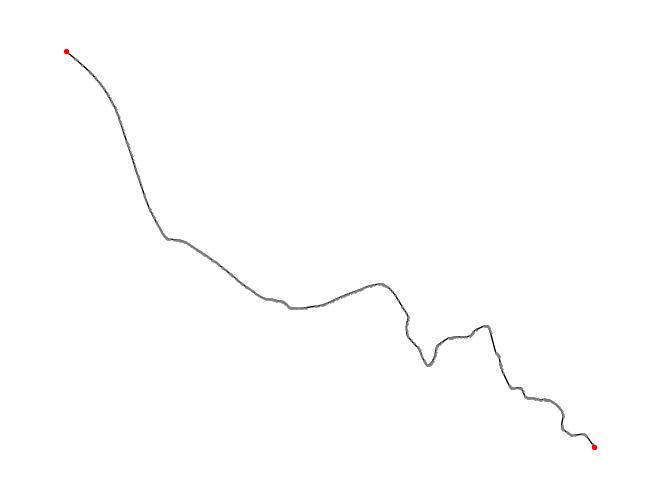

1
Circle


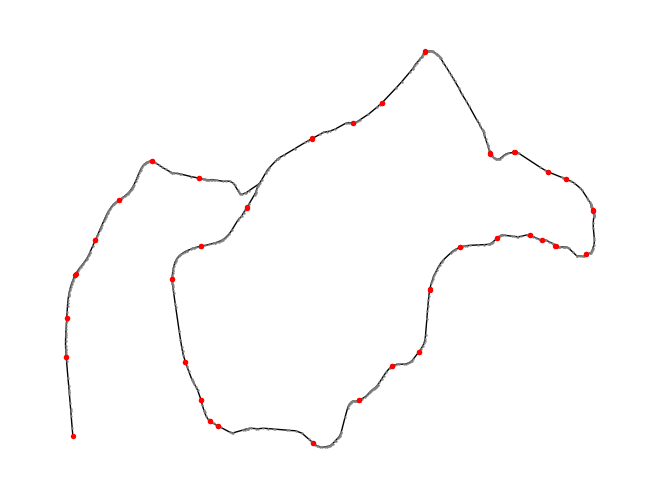

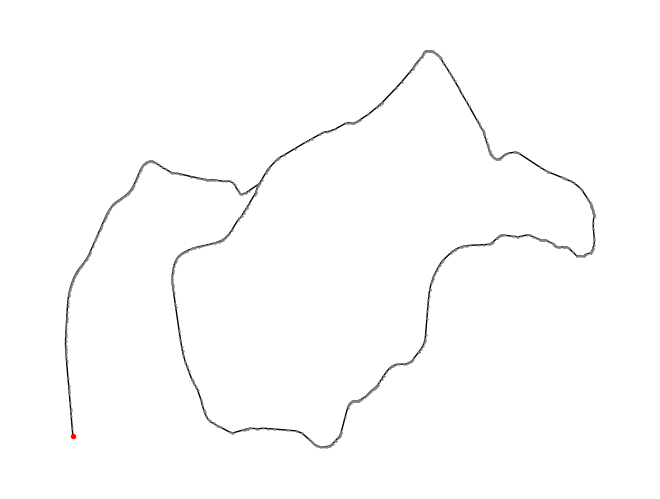

1


In [12]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G

#### Create seperate graphs for each line and then join

In [13]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

In [14]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs

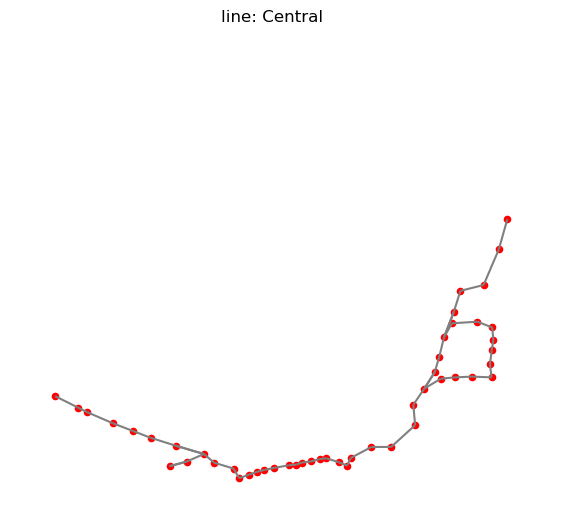

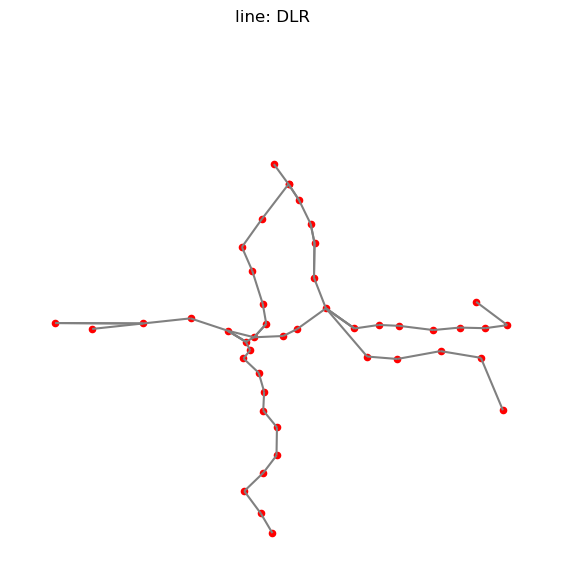

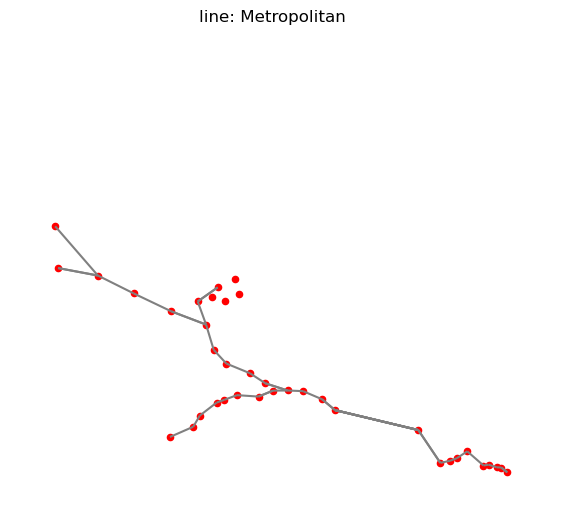

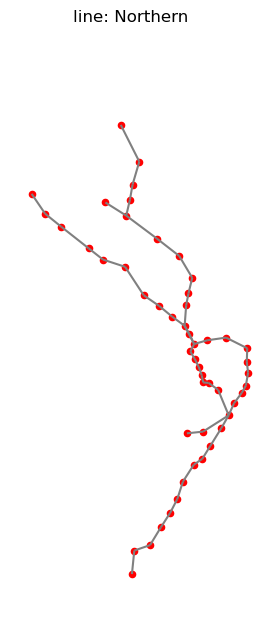

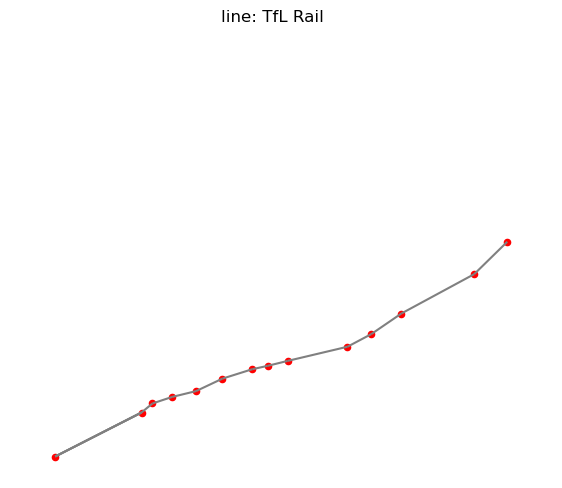

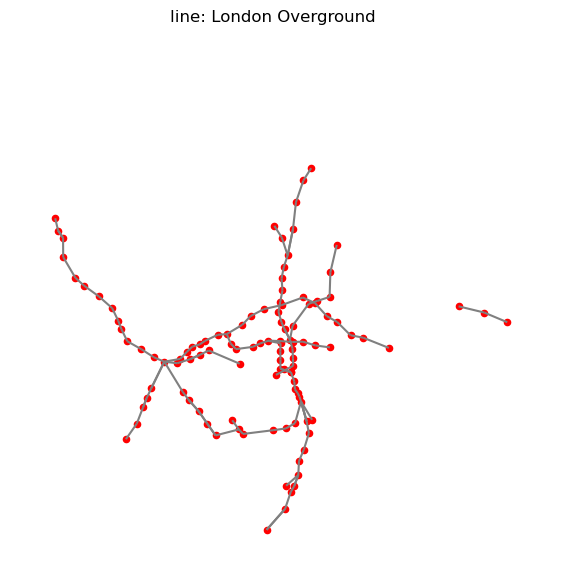

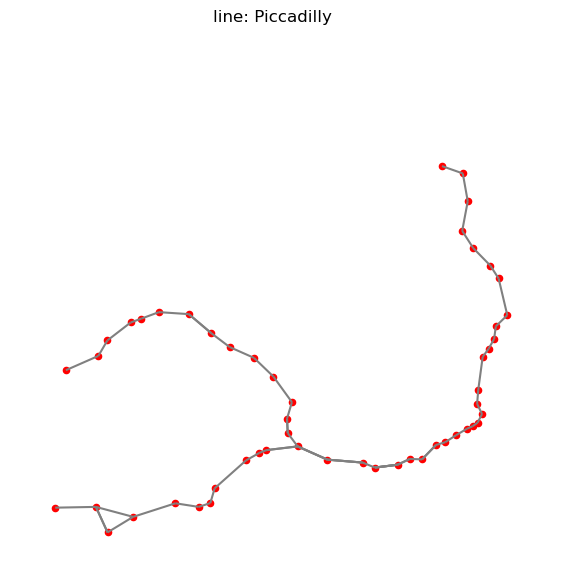

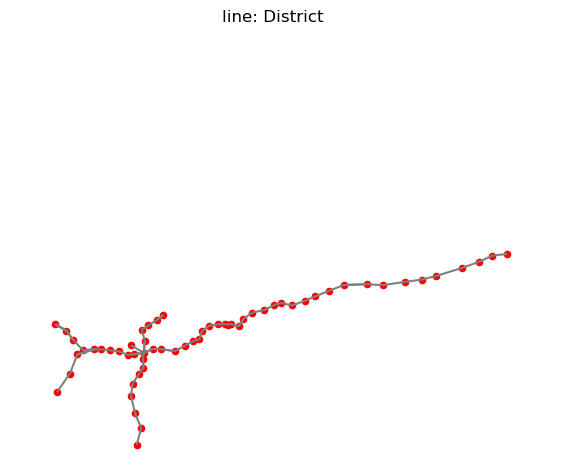

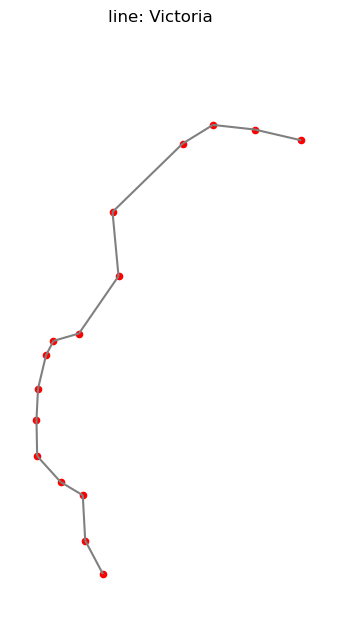

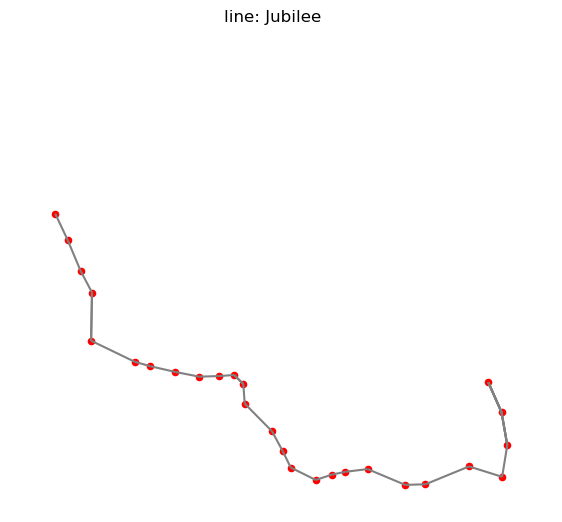

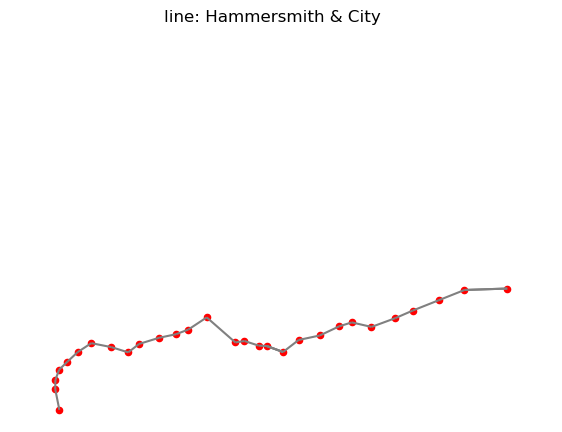

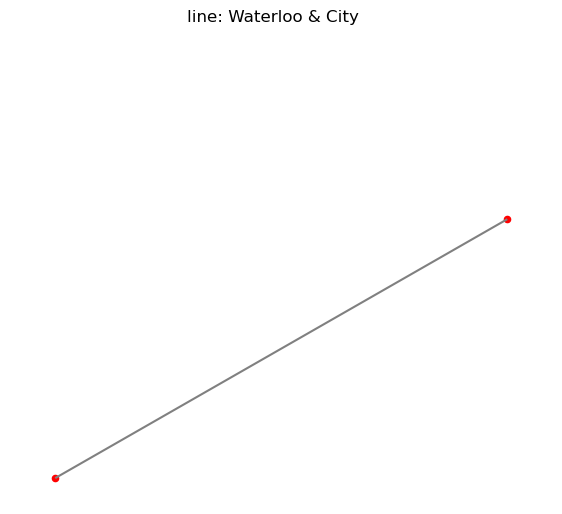

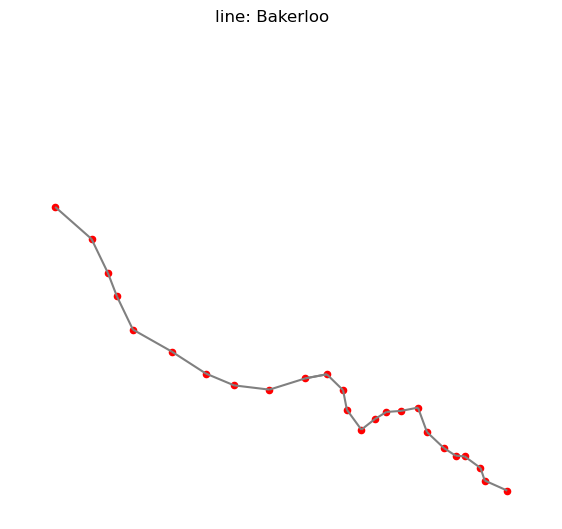

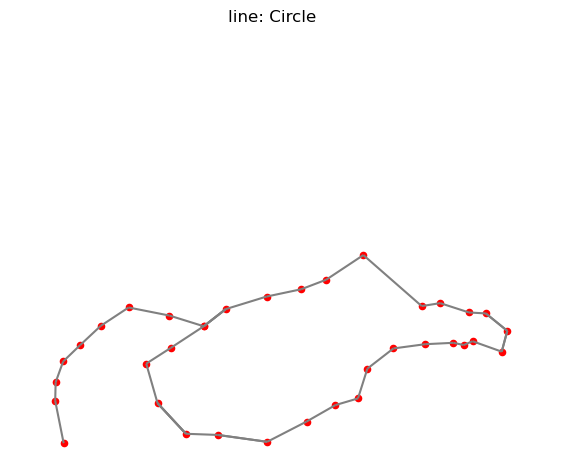

In [15]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<AxesSubplot: >

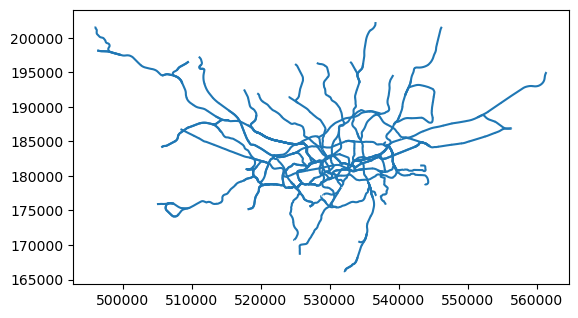

In [16]:
#plot to sanity check
edge_gdf.plot()

In [17]:
# store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [18]:
# this is our resulting dataframe
edge_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   line_name  636 non-null    object  
 1   start_id   636 non-null    object  
 2   end_id     636 non-null    object  
 3   geometry   636 non-null    geometry
 4   length     636 non-null    float64 
dtypes: float64(1), geometry(1), object(3)
memory usage: 25.0+ KB


In [19]:
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Central,940GZZLUWTA,940GZZLUEBY,"LINESTRING (519396.497 181320.536, 519397.598 ...",1616.902167
1,Central,940GZZLUWTA,940GZZLUNAN,"LINESTRING (519396.497 181320.536, 519397.598 ...",1811.494775
2,Central,940GZZLUEBY,940GZZLUWTA,"LINESTRING (517952.062 180930.321, 517951.526 ...",1616.902167
3,Central,940GZZLUWRP,940GZZLURSG,"LINESTRING (508377.638 186796.268, 508378.966 ...",2124.393196
4,Central,940GZZLURSG,940GZZLUSRP,"LINESTRING (510274.963 185847.936, 510276.292 ...",885.885726


In [20]:
#let's replace the ids with the actual nane
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [21]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Central,West Acton,Ealing Broadway,"LINESTRING (519396.497 181320.536, 519397.598 ...",1616.902167
1,Central,West Acton,North Acton,"LINESTRING (519396.497 181320.536, 519397.598 ...",1811.494775
2,Central,Ealing Broadway,West Acton,"LINESTRING (517952.062 180930.321, 517951.526 ...",1616.902167
3,Central,West Ruislip,Ruislip Gardens,"LINESTRING (508377.638 186796.268, 508378.966 ...",2124.393196
4,Central,Ruislip Gardens,South Ruislip,"LINESTRING (510274.963 185847.936, 510276.292 ...",885.885726


#### create the topological network

In [308]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'Central', 'DLR', 'Bakerloo', 'District', 'Metropolitan', 'Northern', 'Waterloo & City', 'Victoria', 'Circle', 'TfL Rail', 'London Overground', 'Jubilee', 'Piccadilly', 'Hammersmith & City'}


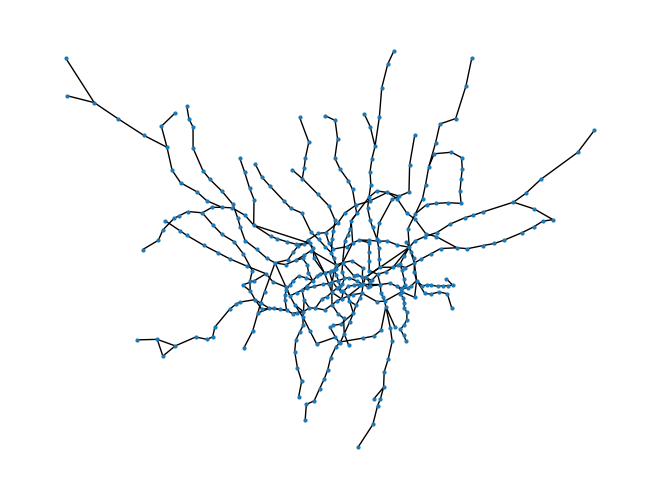

In [309]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [310]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [25]:
type(G)

networkx.classes.graph.Graph

In [26]:
# To check node attributes:
list(G.nodes(data = True))[0]

('West Acton', {'coords': (519396.4966177136, 181320.53600355366)})

In [27]:
# To check edges attributes:
list(G.edges(data = True))[0]

('West Acton',
 'Ealing Broadway',
 {'length': 1616.9021668199223, 'line_name': 'Central'})

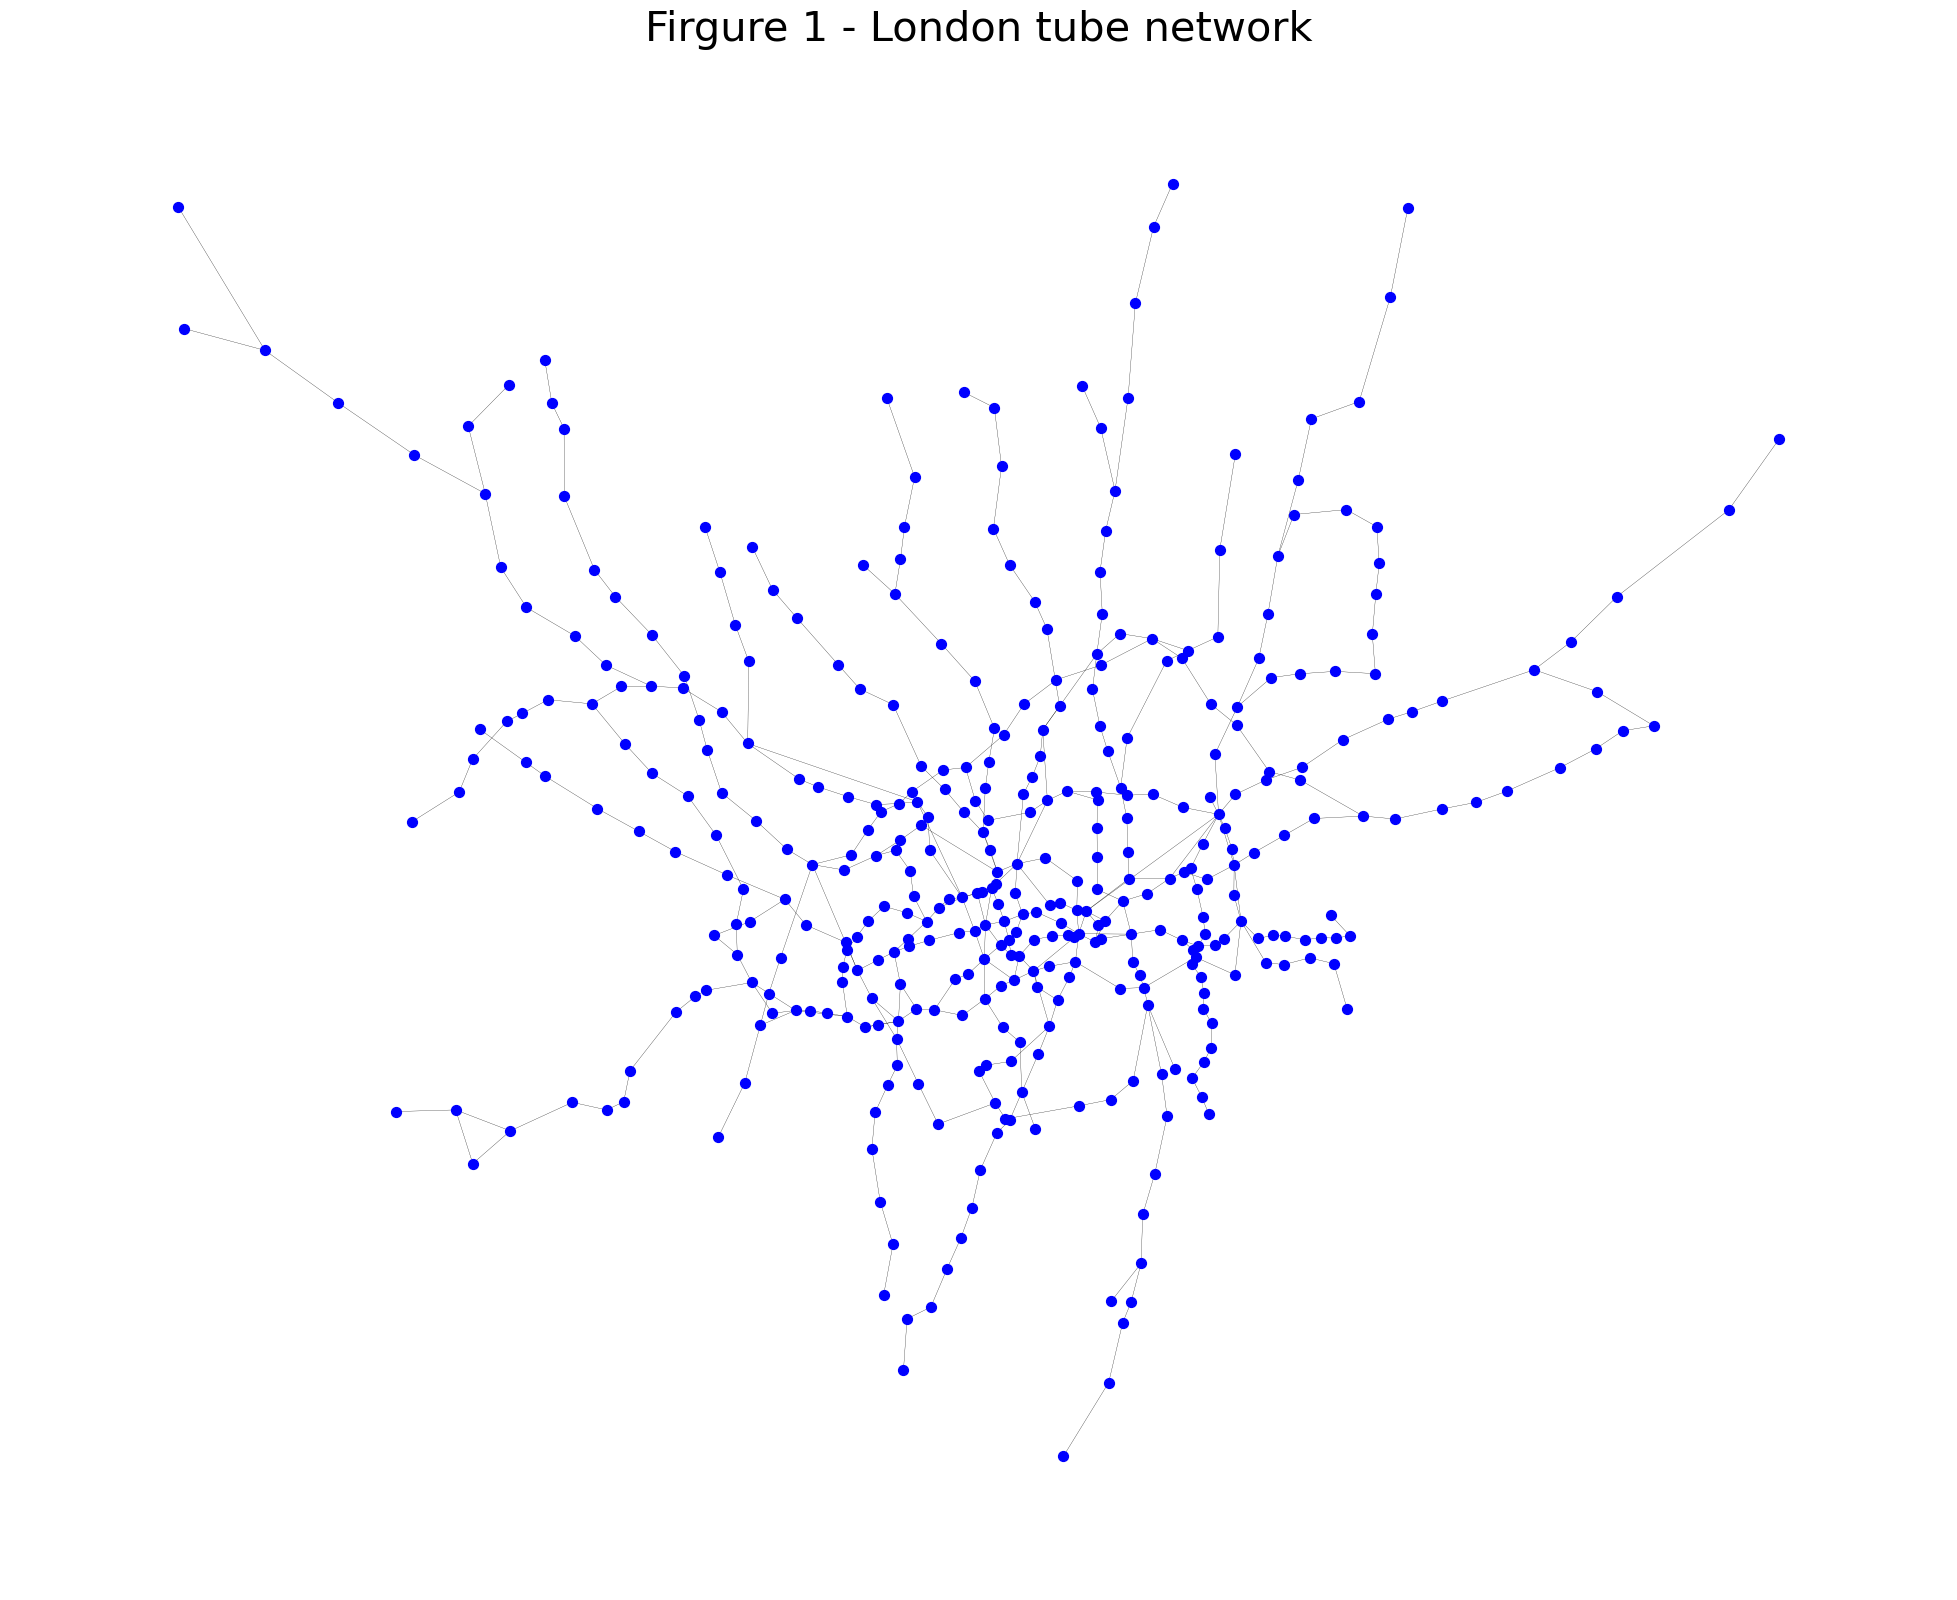

In [311]:
# plot the tube network

fig, ax = plt.subplots(figsize=(25,20))


pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)

plt.title("Firgure 1 - London tube network",fontsize=30)
plt.axis("off")

plt.savefig('img/tube.png')
plt.show()

In [29]:
# We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(G)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source     467 non-null    object 
 1   target     467 non-null    object 
 2   line_name  467 non-null    object 
 3   length     467 non-null    float64
dtypes: float64(1), object(3)
memory usage: 14.7+ KB


In [30]:
df.head(10)

,source,target,line_name,length
0,West Acton,Ealing Broadway,Central,1616.902167
1,West Acton,North Acton,Central,1811.494775
2,Ealing Broadway,Ealing Common,District,1565.297083
3,North Acton,Hanger Lane,Central,2454.293349
4,North Acton,East Acton,Central,1180.519316
5,West Ruislip,Ruislip Gardens,Central,2124.393196
6,Ruislip Gardens,South Ruislip,Central,885.885726
7,South Ruislip,Northolt,Central,2323.990521
8,Northolt,Greenford,Central,1818.466260
9,Greenford,Perivale,Central,1596.435121


### I.1 Centrality measures:

Select **3 centrality measures** to characterise nodes, aiming at identifying the most important nodes in this particular network. Give the **definition of each of the measures (including their equation)**, put the measures into the context of the underground, and why they will allow you to find the **stations that are most crucial** for the functioning of the underground. Compute the measures for your nodes in the network, and give the results in **a table for the first 10 ranked nodes for each of the 3 measures**. 

#### I.1.1 Degree Centrality

\begin{equation} \tag{1}
Cd_i = \frac{k_i}{N-1} \sum_{j}^{i} A_{ij}
\end{equation}

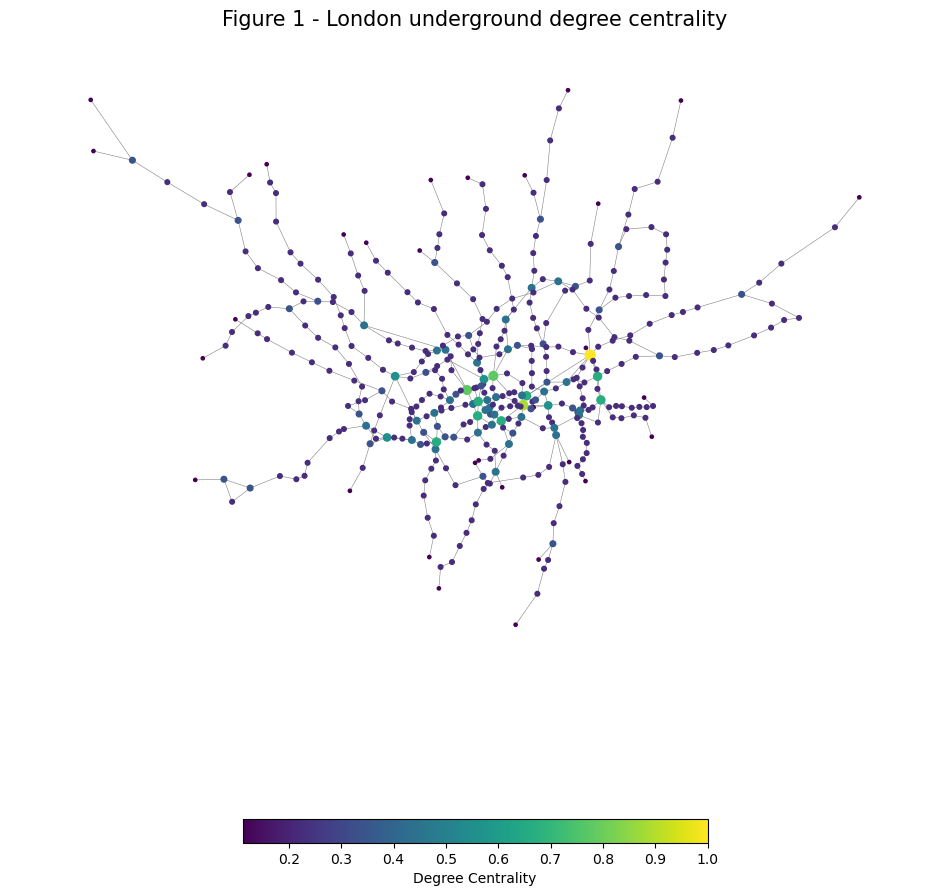

In [312]:
# Calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Figure 1 - London underground degree centrality",fontsize=15)

plt.savefig('img/dc.png')

plt.show()

#### I.1.2 Betweenness  Centrality 

Topological Betweeness Centrality without using weights

\begin{equation} \tag{2}
Cb_i = \frac{1}{n^2} \sum_{st} \frac{ni_{st}}{g_{st}}
\end{equation}

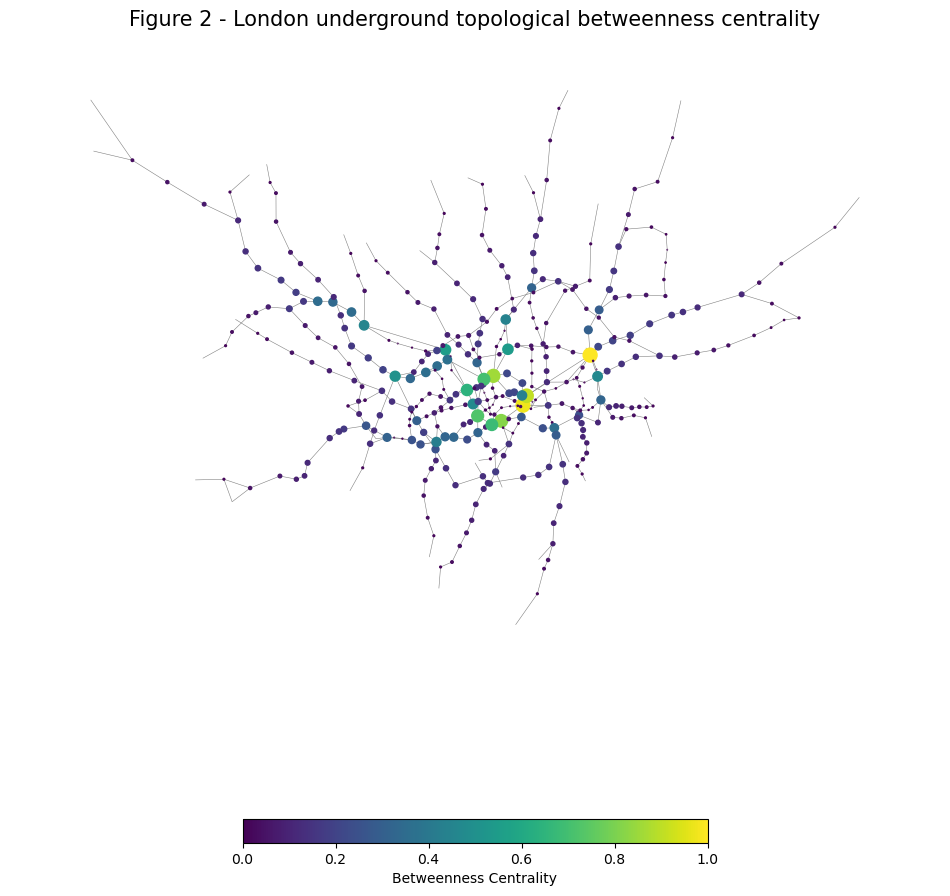

In [313]:
### Topological betweenness centrality:
#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')


# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Figure 2 - London underground topological betweenness centrality",fontsize=15)

plt.savefig('img/bc.png')
plt.show()

#### I.1.3 Closeness  Centrality

Topological Closeness Centrality without using weights

\begin{equation} \tag{3}
Cc_i = \frac{1}{l^2} = \frac{n}{\sum_j d_{ij}}
\end{equation}

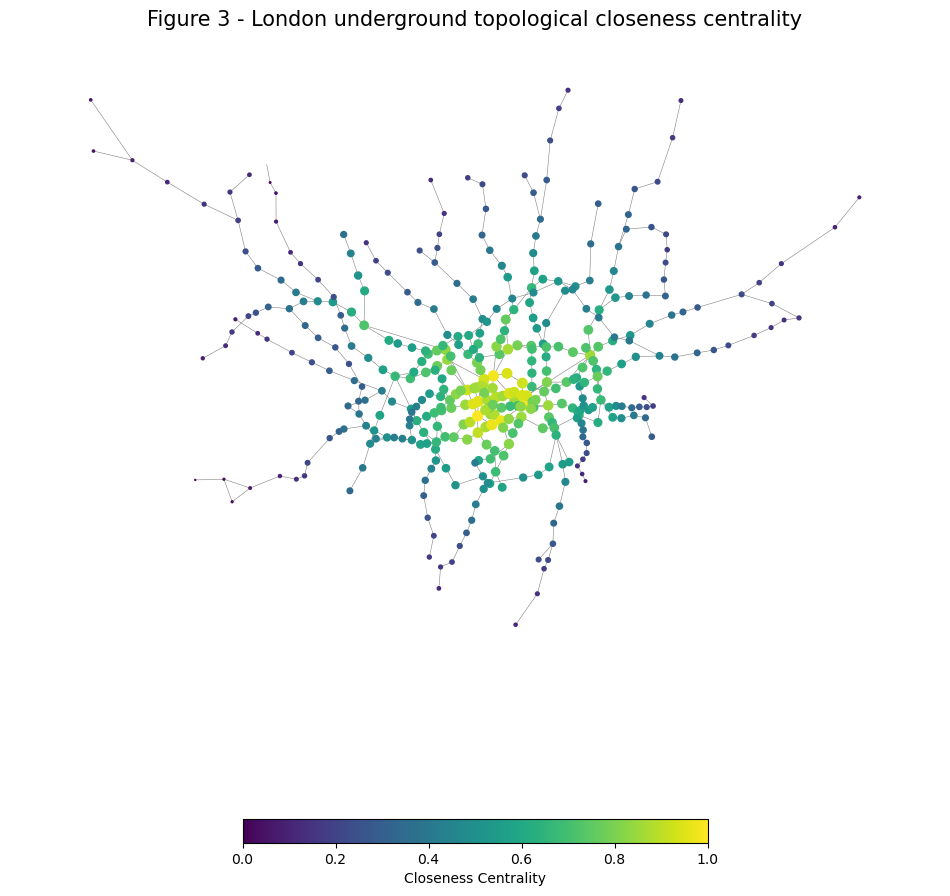

In [314]:
#topological closeness centrality
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Figure 3 - London underground topological closeness centrality",fontsize=15)

plt.savefig('img/cc.png')
plt.show()

#### I.1.4 Results

In [336]:
# Compute degree centrality
degree_centrality = nx.degree_centrality(G)

# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

# Compute closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Combine the results into a single DataFrame
df = pd.DataFrame({'Station': list(G.nodes),
                   'Degree Centrality': list(degree_centrality.values()),
                   'Betweenness Centrality': list(betweenness_centrality.values()),
                   'Closeness Centrality': list(closeness_centrality.values())})

# Sort the DataFrame by each centrality measure
df_degree = df.sort_values(by='Degree Centrality', ascending=False).reset_index(drop=True)
df_betweenness = df.sort_values(by='Betweenness Centrality', ascending=False).reset_index(drop=True)
df_closeness = df.sort_values(by='Closeness Centrality', ascending=False).reset_index(drop=True)

# Print the top 10 stations for each centrality measure
df1 = df_degree[:10][['Station','Degree Centrality']]

df2 = df_betweenness[:10][['Station','Betweenness Centrality']]

df3 = df_closeness[:10][['Station','Closeness Centrality']]

centrality_results = pd.concat([df1, df2, df3], axis=1)

centrality_results

,Station,Degree Centrality,Station,Betweenness Centrality,Station,Closeness Centrality
0,Stratford,0.0225,Stratford,0.297846,Green Park,0.114778
1,Bank and Monument,0.0200,Bank and Monument,0.290489,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.0175,Liverpool Street,0.270807,King's Cross St. Pancras,0.113443
3,Baker Street,0.0175,King's Cross St. Pancras,0.255307,Westminster,0.112549
4,Oxford Circus,0.0150,Waterloo,0.243921,Waterloo,0.112265
5,West Ham,0.0150,Green Park,0.215835,Oxford Circus,0.111204
6,Canning Town,0.0150,Euston,0.208324,Bond Street,0.110988
7,Green Park,0.0150,Westminster,0.203335,Angel,0.110742
8,Liverpool Street,0.0150,Baker Street,0.191568,Farringdon,0.110742
9,Earl's Court,0.0150,Finchley Road,0.165085,Moorgate,0.110314


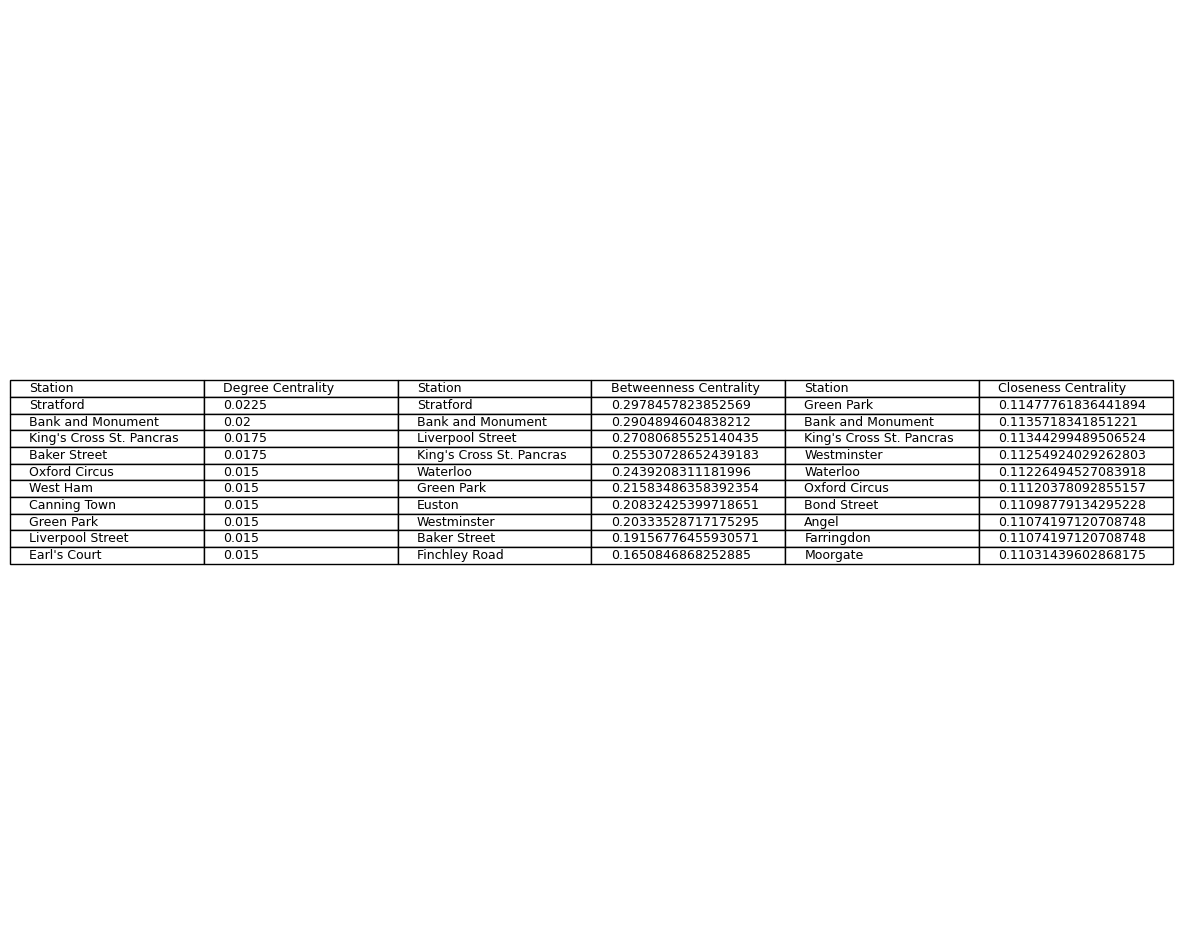

In [337]:
table1 = [centrality_results.columns.tolist()] + centrality_results.values.tolist()

fig, ax = plt.subplots(figsize=(15, 12))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=table1, colLabels=None, cellLoc='left', loc='center')
plt.savefig('img/table1.png')

plt.show()

### I.2. Impact measures:

refering to:

[Bellingeri et.al 's paper](https://www.frontiersin.org/articles/10.3389/fphy.2020.00228/full)

[Latora & Marchiori 's paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.87.198701)

#### I.2.1 LCC

Largest Connected Component of the original London tube network

\begin{equation} \tag{4}
LCC = max_j (S_j)
\end{equation}

In [35]:
G_components = G.copy()
# get the connected components 
nx.number_connected_components(G_components)

1

In [36]:
components = nx.connected_components(G_components)

# get the largest one
largest_component = max(components, key=len)

# Create a "subgraph" of the largest component
Largest_subgraph = G_components.subgraph(largest_component)

In [37]:
# To coumpute the size (nodes) of the largest component:
size = Largest_subgraph.number_of_nodes()
size

401

In [38]:
# You can compute the diameter of this new graph 
diameter = nx.diameter(Largest_subgraph)
diameter 

36

In [39]:
lcc_G = len(max(nx.connected_components(G), key=len))

lcc_G

401

#### I.2.2 Eff

Network Efficiency of the original network

\begin{equation} \tag{5}
EFF = \frac{1}{N(N-1)} \sum_{i\neq j \in G} \frac{1}{d_{ij}}
\end{equation}

In [40]:
G_eff = G.copy()

efficiency = nx.global_efficiency(G_eff)

print("Network efficiency:", efficiency)

Network efficiency: 0.101256193597224


In [41]:
# test this function which will be used for weighted global efficiency
def eff(G):
    shortest_paths = dict(nx.shortest_path_length(G))
    for node in shortest_paths:
        shortest_paths[node] = {k:v for k,v in shortest_paths[node].items() if v != 0}
    n = len(G.nodes)
    eff = sum(1/(d_ij) for source in shortest_paths for d_ij in shortest_paths[source].values())/(n*(n-1))
    
    return eff

In [42]:
eff(G_eff)

0.101256193597224

### I.3. Node removal:

In [43]:
# Define the centrality measures to be used.
centrality_measures = {
    "degree_centrality": nx.degree_centrality,
    "betweenness_centrality": nx.betweenness_centrality,
    "closeness_centrality": nx.closeness_centrality
}

# Define the removal strategies.
removal_strategies = ["non-sequential", "sequential"]

# Define the number of nodes to remove.
num_nodes_to_remove = 15

# Define a dataframe to save the results
results = pd.DataFrame()

# Iterate over the centrality measures and removal strategies.
for centrality_measure_name, centrality_measure_func in centrality_measures.items():
    for removal_strategy in removal_strategies:
        print(f"Centrality measure: {centrality_measure_name}")
        print(f"Removal strategy: {removal_strategy}")

        # Create a copy of the original graph.
        H = G.copy()
        
        # Compute the centrality measure for each node.
        centrality = centrality_measure_func(H)

        # Sort the nodes by their centrality score.
        sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

        # Remove nodes according to the selected removal strategy.
        if removal_strategy == "non-sequential":
            nodes_to_remove = [node[0] for node in sorted_nodes[:num_nodes_to_remove]]

            for node in nodes_to_remove:
                H.remove_node(node)

                # Compute the largest connected component and network efficiency.
                lcc = len(max(nx.connected_components(H), key=len)) #/ H.number_of_nodes()
                eff = nx.global_efficiency(H)

                print(f"Removed node: {node}, LCC: {lcc:.0f}, EFF: {eff:.4f}")

                row = pd.DataFrame({'Removed_node': node,
                        'LCC': lcc, "EFF": eff}, index=[0])
                results = pd.concat([results, row], ignore_index = True)

        elif removal_strategy == "sequential":
            for i in range(num_nodes_to_remove):
                node_to_remove = sorted_nodes[i][0]

                # Compute the largest connected component and network efficiency before removing the node.
                lcc_before = len(max(nx.connected_components(H), key=len)) #/ H.number_of_nodes()
                eff_before = nx.global_efficiency(H)

                # Remove the node and compute the largest connected component and network efficiency after removing the node.
                H.remove_node(node_to_remove)
                lcc_after = len(max(nx.connected_components(H), key=len)) #/ H.number_of_nodes()
                eff_after = nx.global_efficiency(H)

                # Compute the change in the largest connected component and network efficiency.
                lcc_change = lcc_before - lcc_after
                eff_change = eff_before - eff_after

                print(f"Removed node: {node_to_remove}, LCC: {lcc_after:.0f}, EFF: {eff_after:.4f}")
                
                row = pd.DataFrame({'Removed_node': node_to_remove,
                        'LCC': lcc_after, "EFF": eff_after}, index=[0])
                results = pd.concat([results, row], ignore_index = True)

                # Recompute the centrality measure for each node.
                centrality = centrality_measure_func(H)

                # Sort the nodes by their centrality score.
                sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Note: This code assumes that the London Tube network is stored in a file named "london_tube.edgelist" in the current directory. You may need to adjust the file name and path if your data


Centrality measure: degree_centrality
Removal strategy: non-sequential
Removed node: Stratford, LCC: 379, EFF: 0.0889
Removed node: Bank and Monument, LCC: 378, EFF: 0.0859
Removed node: Baker Street, LCC: 377, EFF: 0.0820
Removed node: King's Cross St. Pancras, LCC: 374, EFF: 0.0757
Removed node: Oxford Circus, LCC: 372, EFF: 0.0744
Removed node: Liverpool Street, LCC: 366, EFF: 0.0726
Removed node: West Ham, LCC: 363, EFF: 0.0700
Removed node: Canning Town, LCC: 348, EFF: 0.0660
Removed node: Waterloo, LCC: 347, EFF: 0.0645
Removed node: Earl's Court, LCC: 346, EFF: 0.0628
Removed node: Green Park, LCC: 345, EFF: 0.0621
Removed node: Shadwell, LCC: 343, EFF: 0.0594
Removed node: Euston, LCC: 320, EFF: 0.0538
Removed node: Willesden Junction, LCC: 306, EFF: 0.0451
Removed node: Turnham Green, LCC: 300, EFF: 0.0431
Centrality measure: degree_centrality
Removal strategy: sequential
Removed node: Stratford, LCC: 379, EFF: 0.0889
Removed node: Baker Street, LCC: 378, EFF: 0.0850
Removed n

In [44]:
results

,Removed_node,LCC,EFF
0,Stratford,379,0.088917
1,Bank and Monument,378,0.085862
2,Baker Street,377,0.082033
3,King's Cross St. Pancras,374,0.075700
4,Oxford Circus,372,0.074396
...,...,...,...
85,Imperial Wharf,367,0.075363
86,Arsenal,366,0.074189
87,Bethnal Green,365,0.071557
88,East Ham,364,0.065910


##### non-sequential

In [45]:
results1_dc = results[:15].reset_index().rename(columns={'Removed_node': 'DC_Removed_node_A', 'LCC': 'DC_LCC_A', 'EFF': 'DC_EFF_A'})
results1_bc = results[30:45].reset_index().rename(columns={'Removed_node': 'BC_Removed_node_A', 'LCC': 'BC_LCC_A', 'EFF': 'BC_EFF_A'})
results1_cc = results[60:75].reset_index().rename(columns={'Removed_node': 'CC_Removed_node_A', 'LCC': 'CC_LCC_A', 'EFF': 'CC_EFF_A'})

results1_final = pd.concat([results1_dc, results1_bc, results1_cc], axis=1)

results1_final = results1_final.drop(columns='index')

results1_final

,DC_Removed_node_A,DC_LCC_A,DC_EFF_A,BC_Removed_node_A,BC_LCC_A,BC_EFF_A,CC_Removed_node_A,CC_LCC_A,CC_EFF_A
0,Stratford,379,0.088917,Stratford,379,0.088917,Green Park,400,0.099190
1,Bank and Monument,378,0.085862,Bank and Monument,378,0.085862,Bank and Monument,399,0.094872
2,Baker Street,377,0.082033,Liverpool Street,377,0.084963,King's Cross St. Pancras,398,0.087934
3,King's Cross St. Pancras,374,0.075700,King's Cross St. Pancras,371,0.078498,Westminster,397,0.087372
4,Oxford Circus,372,0.074396,Waterloo,370,0.075942,Waterloo,396,0.084859
5,Liverpool Street,366,0.072601,Green Park,369,0.074152,Oxford Circus,395,0.082781
6,West Ham,363,0.070024,Euston,346,0.068206,Bond Street,394,0.082581
7,Canning Town,348,0.066018,Westminster,345,0.067660,Farringdon,393,0.082600
8,Waterloo,347,0.064459,Baker Street,342,0.064700,Angel,392,0.082622
9,Earl's Court,346,0.062780,Finchley Road,339,0.063139,Moorgate,389,0.081670


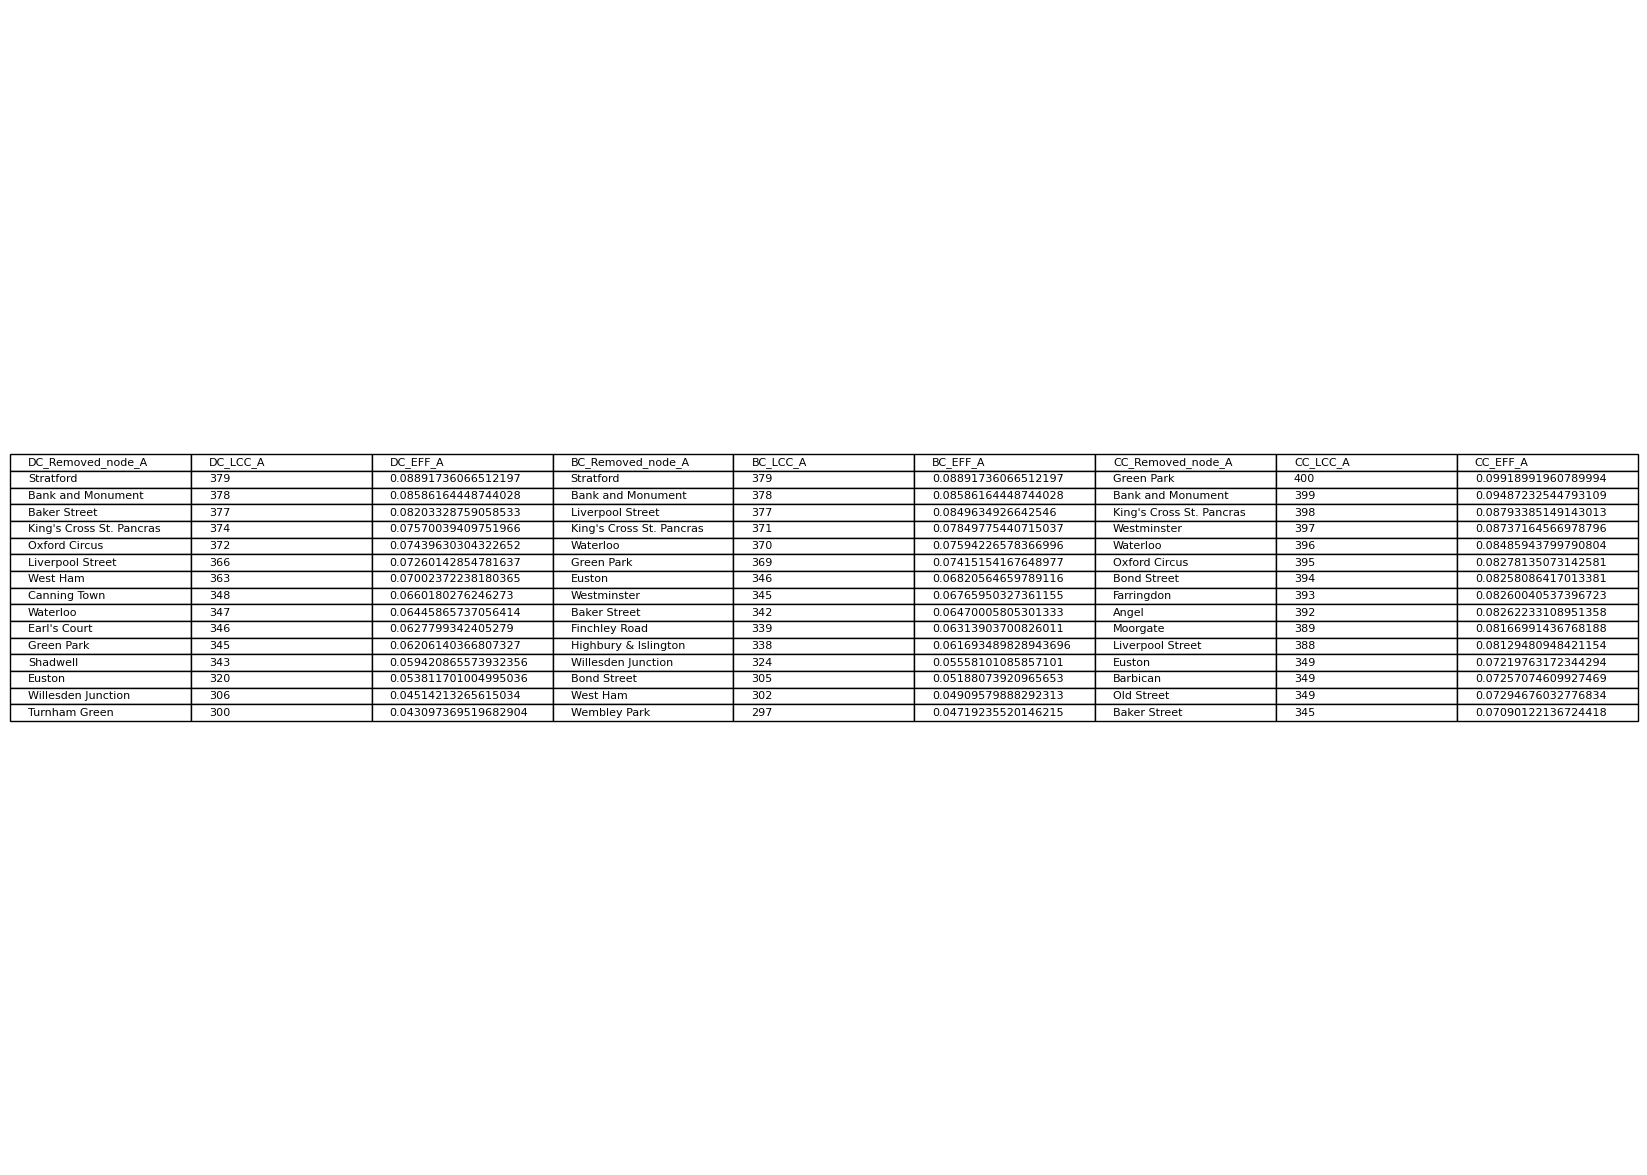

In [322]:
table2 = [results1_final.columns.tolist()] + results1_final.values.tolist()

fig, ax = plt.subplots(figsize=(21, 15))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=table2, colLabels=None, cellLoc='left', loc='center')
plt.savefig('img/nonsequential.png')

plt.show()

##### sequential

In [46]:
results2_dc = results[15:30].reset_index().rename(columns={'Removed_node': 'DC_Removed_node_B', 'LCC': 'DC_LCC_B', 'EFF': 'DC_EFF_B'})
results2_bc = results[45:60].reset_index().rename(columns={'Removed_node': 'BC_Removed_node_B', 'LCC': 'BC_LCC_B', 'EFF': 'BC_EFF_B'})
results2_cc = results[75:90].reset_index().rename(columns={'Removed_node': 'CC_Removed_node_B', 'LCC': 'CC_LCC_B', 'EFF': 'CC_EFF_B'})

results2_final = pd.concat([results2_dc, results2_bc, results2_cc], axis=1)

results2_final = results2_final.drop(columns='index')

results2_final

,DC_Removed_node_B,DC_LCC_B,DC_EFF_B,BC_Removed_node_B,BC_LCC_B,BC_EFF_B,CC_Removed_node_B,CC_LCC_B,CC_EFF_B
0,Stratford,379,0.088917,Stratford,379,0.088917,Green Park,400,0.099190
1,Baker Street,378,0.085012,Bank and Monument,378,0.085862,Farringdon,399,0.098900
2,Oxford Circus,376,0.083648,Highbury & Islington,377,0.082870,Moorgate,397,0.096852
3,Waterloo,375,0.081715,Baker Street,376,0.078816,Holborn,396,0.096056
4,Liverpool Street,374,0.080976,West Hampstead,375,0.075700,Westminster,395,0.094866
5,Shadwell,372,0.079560,Willesden Junction,358,0.069861,Euston,372,0.086103
6,Willesden Junction,358,0.073042,King's Cross St. Pancras,355,0.064885,Piccadilly Circus,371,0.085369
7,Green Park,357,0.072088,Canary Wharf,344,0.059878,Highbury & Islington,370,0.083099
8,Holborn,356,0.071480,Barons Court,343,0.058075,Tottenham Court Road,369,0.080718
9,Poplar,350,0.069750,Ealing Common,301,0.051490,Vauxhall,368,0.079120


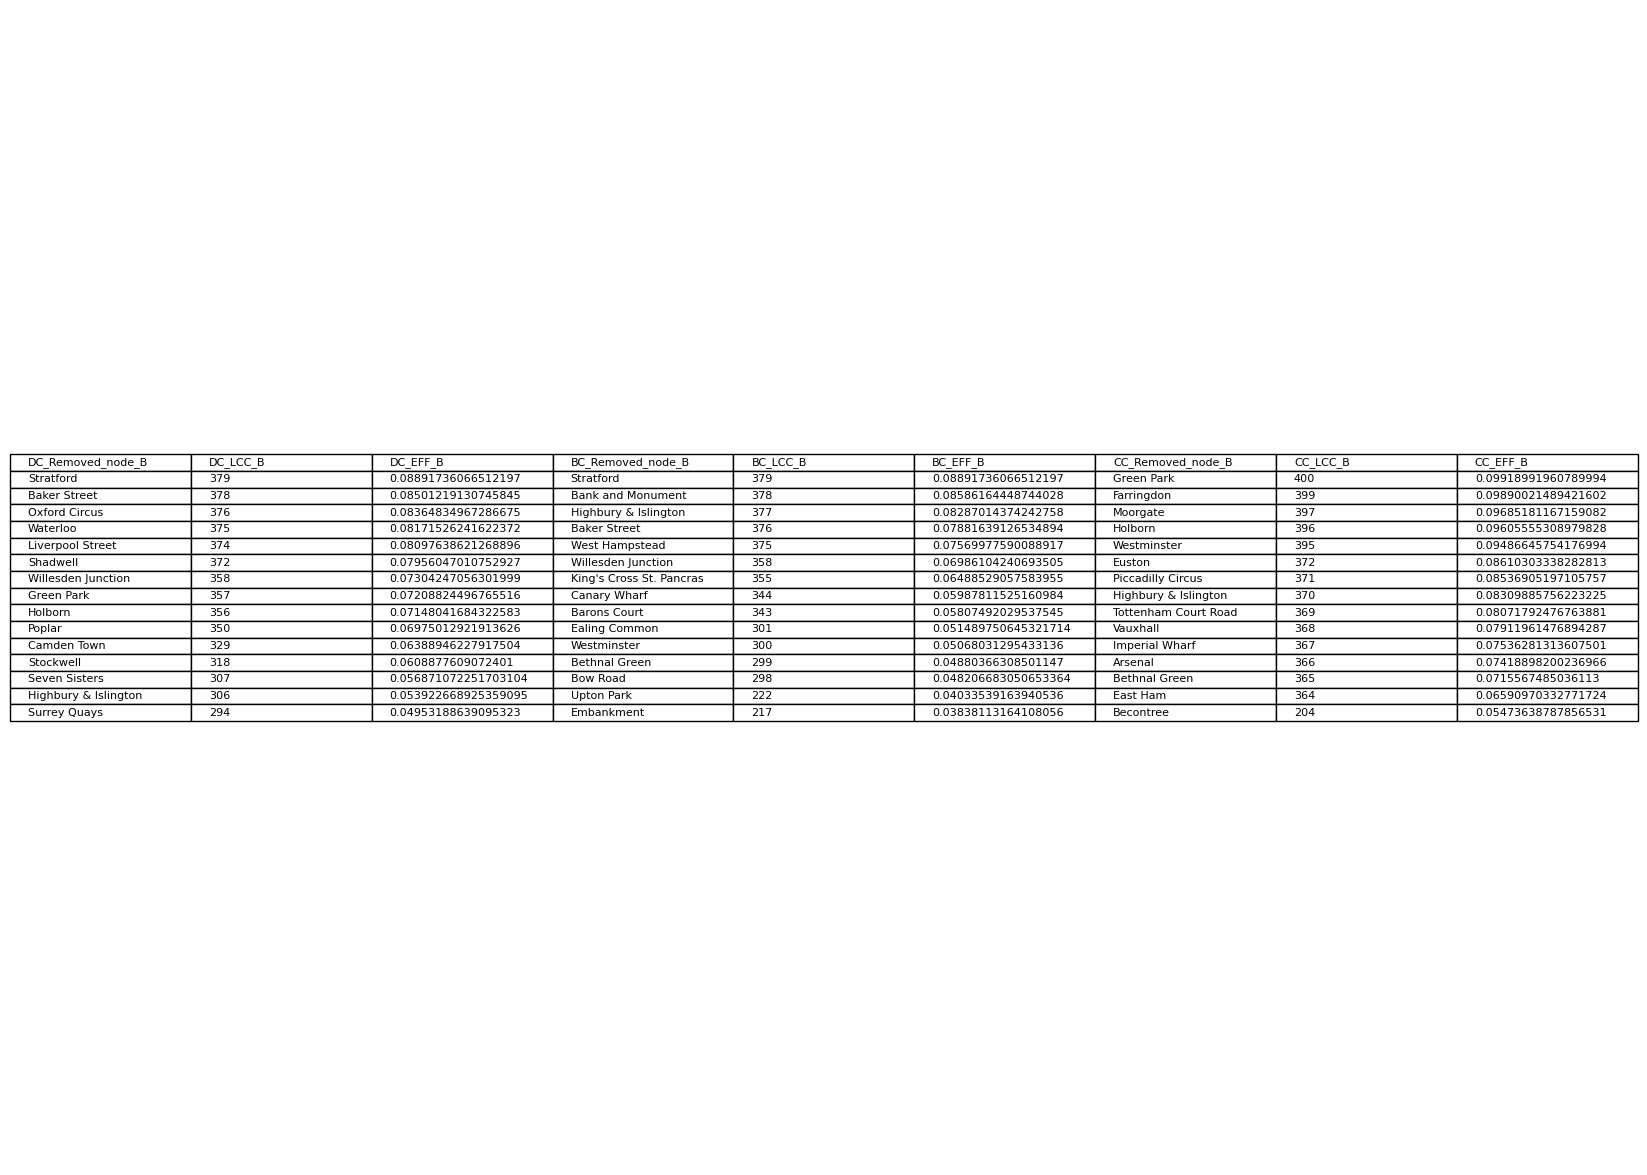

In [323]:
table3 = [results2_final.columns.tolist()] + results2_final.values.tolist()

fig, ax = plt.subplots(figsize=(21, 15))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=table3, colLabels=None, cellLoc='left', loc='center')
plt.savefig('img/sequential.png')

plt.show()

## II. Flows: weighted network


#### Merge data with OD flows

In [47]:
london_OD = pd.read_csv('Data/london_flows.csv')

london_OD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [48]:
london_OD.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [49]:
#check that our OD data and network data match
OD_names = set(london_OD.station_origin.unique())
network_names = set([n for n in G.nodes()])

# is there any difference
network_names.symmetric_difference(OD_names)

{'Battersea Power Station', 'Nine Elms'}

Battersea power station and Nine Elms data doesn't exist in our TFL data because the station wasn't opened when the data was collected. This was an extension of Northern line that opened recently.

In [50]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Nine Elms', 'Battersea Power Station']

In [51]:
london_OD_new = london_OD[~london_OD.station_origin.isin(_filter)]
london_OD_new = london_OD[~london_OD.station_destination.isin(_filter)]

london_OD_new

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


##### add flows to the data

In [325]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [326]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_new.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [327]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

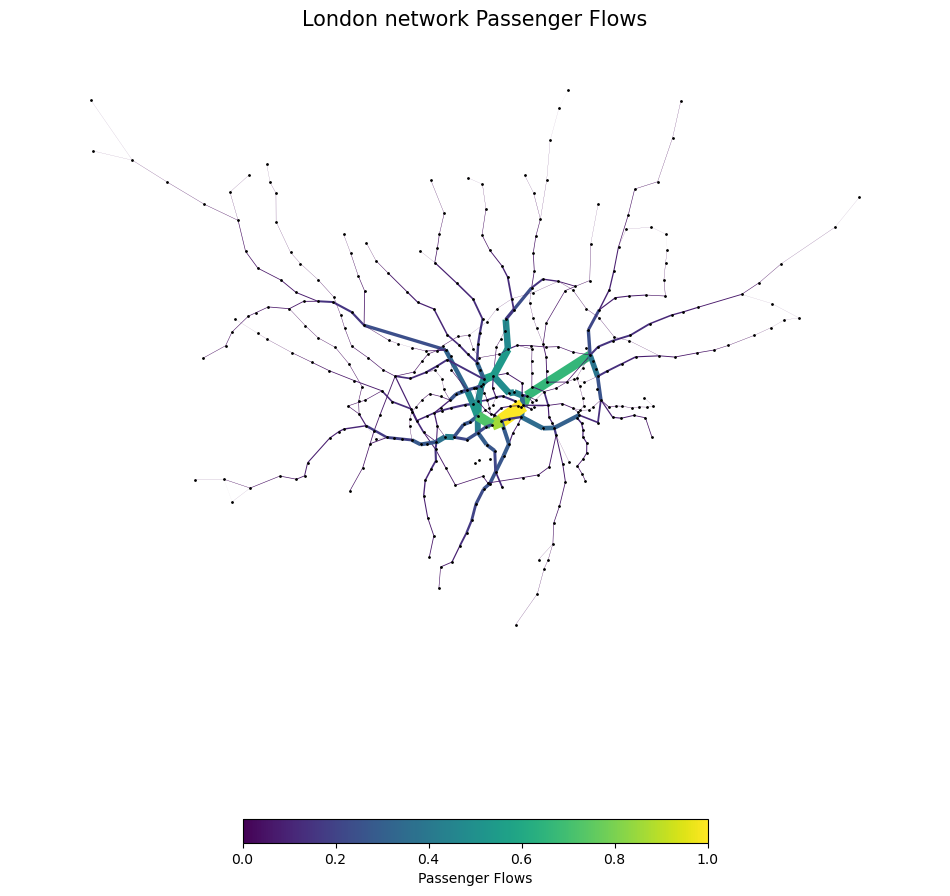

In [328]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)

plt.savefig('img/flows.png')


plt.show()

In [56]:
#get edge with highest number of flows
max(flows, key=flows.get)

('Bank and Monument', 'Waterloo')

In [57]:
#get edge data with lowest number of flows
min(flows, key=flows.get)

('Kennington', 'Nine Elms')

In [58]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "Data/outputs/london.graph")

#### Create OD pairs with distance, population and jobs

In [59]:
#### Create Origin Destination matrix
OD = pd.pivot_table(london_OD_new, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.to_csv('Data/outputs/OD_matrix.csv')

In [60]:
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24735
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,27026
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28307
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29494
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31473
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32597
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37517
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59311
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67372


In [61]:
#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

##### check the flows

In [62]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

df.sort_values('degree', ascending =False).head(20)

,degree
Stratford,9
Bank and Monument,8
King's Cross St. Pancras,7
Baker Street,7
Oxford Circus,6
West Ham,6
Canning Town,6
Green Park,6
Liverpool Street,6
Earl's Court,6


In [63]:
# get the edges that end at Green Park for checking
flows_GP={(u,v):flow for (u,v),flow in flows.items() if v=='Green Park'}
flows_GP

{('Bond Street', 'Green Park'): 122761,
 ('Oxford Circus', 'Green Park'): 124327,
 ('Hyde Park Corner', 'Green Park'): 62159}

In [64]:
# there are 3 lines connected at GP
df['degree']['Green Park']

6

In [65]:
flows_GP={(u,v):flow for (u,v),flow in flows.items() if u=='Green Park' or v=='Green Park'}
flows_GP

{('Bond Street', 'Green Park'): 122761,
 ('Oxford Circus', 'Green Park'): 124327,
 ('Hyde Park Corner', 'Green Park'): 62159,
 ('Green Park', 'Piccadilly Circus'): 9025,
 ('Green Park', 'Victoria'): 98477,
 ('Green Park', 'Westminster'): 166807}

Our Graph is not directed so the flows **into and out** from the station are combined in each edge. We cannot determine the **actual total flows** passing through the station from the current graph as there will be **double counting**.

When flows are considered, we need to reconstruct the network as a Directed Graph.

#### Reconstructing the Network as Directed Graph

In [66]:
# recreate our network but with directional Graph by specifying create_using parameter!
G_Di = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'], create_using=nx.DiGraph)

# we need to add an extra step to iterate through the edges from the opposite direction 
for i, edge in edge_gdf.iterrows():
    if not G_Di.has_edge(edge['end_id'], edge['start_id']):
        G_Di.add_edge(edge['end_id'], edge['start_id'],length= edge['length'], line_name=edge['line_name'])

# Adding the position of the nodes
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G_Di.nodes()}
nx.set_node_attributes(G_Di, pos, 'coords')


{'Central', 'DLR', 'Bakerloo', 'District', 'Metropolitan', 'Northern', 'Waterloo & City', 'Victoria', 'Circle', 'TfL Rail', 'London Overground', 'Jubilee', 'Piccadilly', 'Hammersmith & City'}


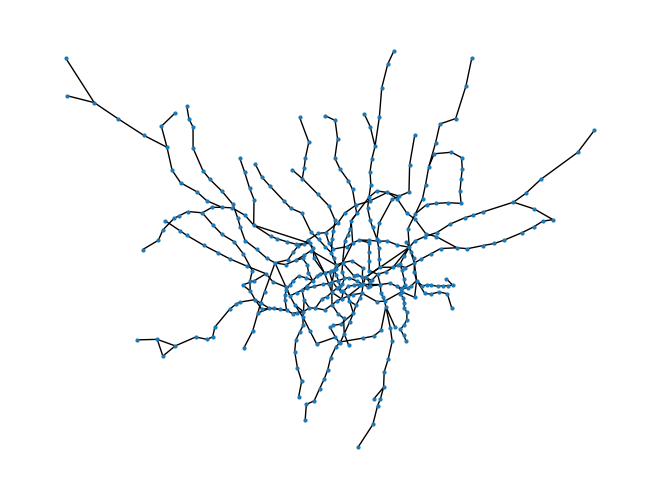

In [67]:
# have a look at how the network looks

lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
print(set(lines))
nx.draw(G_sub, pos, node_size=4)
plt.show()

In [68]:
# check the edges of Green Park again
Green_park = [(u,v) for  u,v in G_Di.edges if v == 'Green Park']
Green_park

[('Bond Street', 'Green Park'),
 ('Oxford Circus', 'Green Park'),
 ('Hyde Park Corner', 'Green Park'),
 ('Piccadilly Circus', 'Green Park'),
 ('Victoria', 'Green Park'),
 ('Westminster', 'Green Park')]

##### add flows in to directed graph

In [69]:
#create a new dictionary to store directional flows for all edges
flows_Di = {(u,v): 0 for u,v in G_Di.edges}
print(f'number of underirected flows: {len(flows)} , number directed flows are {len(flows_Di)}')

number of underirected flows: 467 , number directed flows are 934


In [70]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_new.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G_Di, source, target)

    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 

    
    #add flows to our dict

    #no need to do the exception as in the case of undirected graph since we are covering all possible edges in both directions in our new directed graph.
    for u,v in path_edges:
        flows_Di[(u,v)] += row.flows
    

In [71]:
nx.set_edge_attributes(G_Di, flows_Di, 'flows_Di')

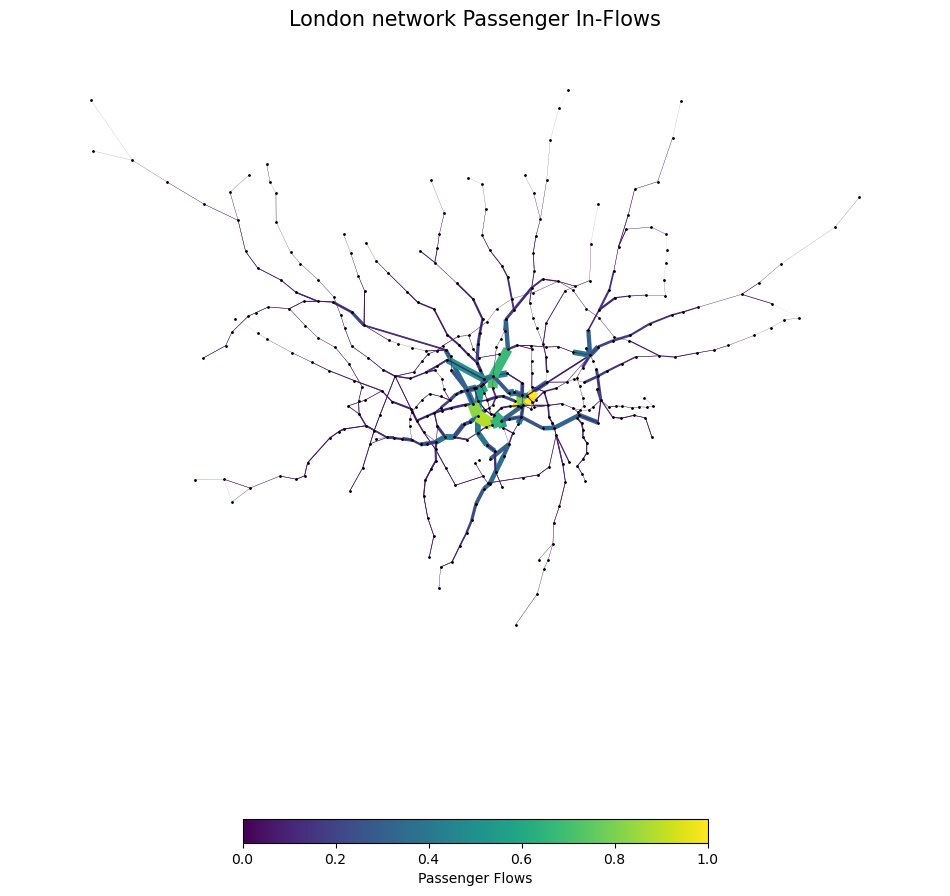

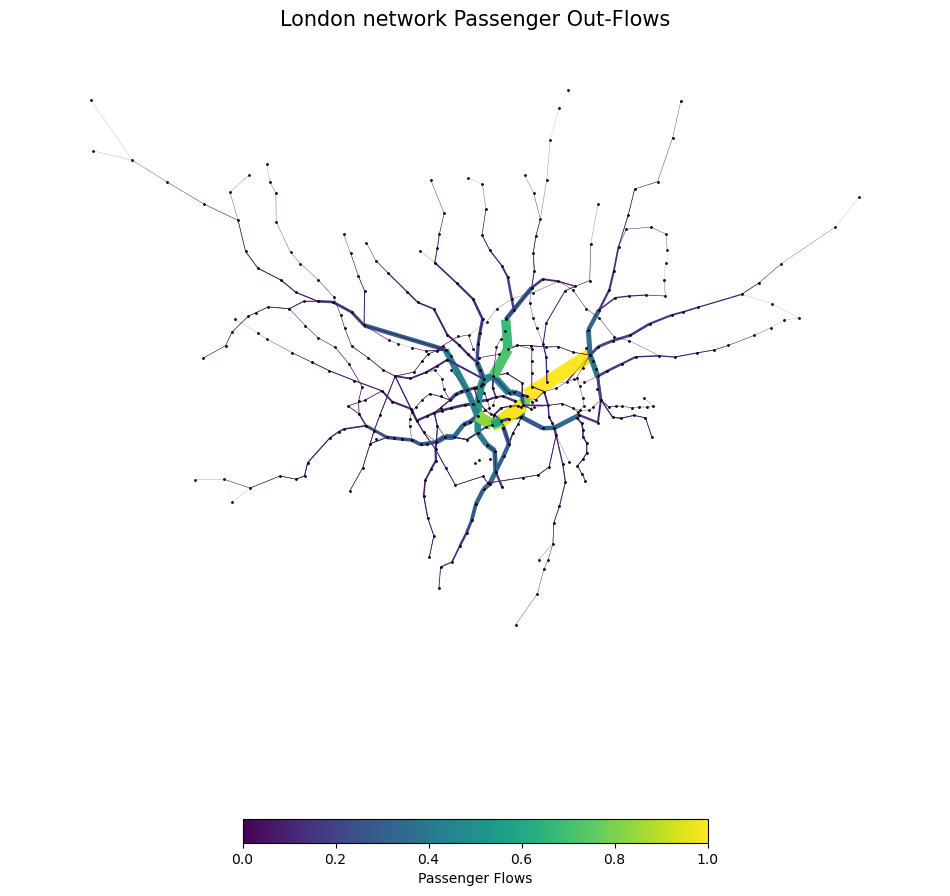

In [72]:
#plot our calcuated flows
flows_values = flows_Di.values()
flow_color=[(i[2]['flows_Di']/max(flows_values)) for i in G_Di.in_edges(data=True)]
flow_width=[(i[2]['flows_Di']/max(flows_values)*10) for i in G_Di.in_edges(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

edg=nx.draw_networkx_edges(G_Di, pos,edge_color=flow_color, width=flow_width, arrows=False)

nx.draw_networkx_nodes(G_Di,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger In-Flows",fontsize=15)
plt.show()

flow_color=[(i[2]['flows_Di']/max(flows_values)) for i in G_Di.in_edges(data=True)]
flow_width=[(i[2]['flows_Di']/max(flows_values)*10) for i in G_Di.in_edges(data=True)]


# Plot graph
flow_color=[(i[2]['flows_Di']/max(flows_values)) for i in G_Di.out_edges(data=True)]
flow_width=[(i[2]['flows_Di']/max(flows_values)*10) for i in G_Di.out_edges(data=True)]
fig, ax = plt.subplots(figsize=(12,12))

edg=nx.draw_networkx_edges(G_Di, pos,edge_color=flow_color, width=flow_width, arrows=False)

nx.draw_networkx_nodes(G_Di,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Out-Flows",fontsize=15)
plt.show()

In [73]:
# check the actual flows coming into the station without double counting
flows_GP={(u,v):flow for (u,v),flow in flows_Di.items() if v=='Green Park'}
flows_GP

{('Bond Street', 'Green Park'): 68256,
 ('Oxford Circus', 'Green Park'): 51894,
 ('Hyde Park Corner', 'Green Park'): 47189,
 ('Piccadilly Circus', 'Green Park'): 2784,
 ('Victoria', 'Green Park'): 67664,
 ('Westminster', 'Green Park'): 115892}

Comparing to the undirected results:

{('Victoria', 'Green Park'): 125586,
 ('Westminster', 'Green Park'): 141134,
 ('Hyde Park Corner', 'Green Park'): 13977,
 ('Green Park', 'Piccadilly Circus'): 20258,
 ('Green Park', 'Oxford Circus'): 134884,
 ('Green Park', 'Bond Street'): 122919}

In [74]:
# get the total flow by adding up the flows coming into the station

total_GP_flows= sum(flows_GP.values())
total_GP_flows

353679

In [75]:
# read the flows terminating at Green Park as a destination from the OD matrix

flows_terminate_GP = OD['Green Park'].loc['All']
flows_terminate_GP

26754

In [76]:
# print the dataframe from G_Di to check the data
df_Di = nx.to_pandas_edgelist(G_Di)
df_Di.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source     934 non-null    object 
 1   target     934 non-null    object 
 2   line_name  934 non-null    object 
 3   flows_Di   934 non-null    int64  
 4   length     934 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 36.6+ KB


In [77]:
df_Di.head()

,source,target,line_name,flows_Di,length
0,West Acton,Ealing Broadway,Central,2406,1616.902167
1,West Acton,North Acton,Central,7171,1811.494775
2,Ealing Broadway,West Acton,Central,6306,1616.902167
3,Ealing Broadway,Ealing Common,District,7065,1565.297083
4,North Acton,Hanger Lane,Central,2985,2454.293349


### II.1. Centrality Measures for weighted network

To adjust the centrality measures for a weighted network, we need to consider the weights of the edges in the computation.

Degree centrality -> Weighted degree centrality: sum the **weights of the edges** incident in each node instead of counting the number of edges.

Betweeness centrality -> Weighted betweeness centrality: we take into account the **weights of the edges** when computing the shortest paths between all pairs of nodes. We can use Dijkstra's algorithm, which takes edge weights into account, to find the shortest paths.

Closeness centrality -> Weighted closeness centrality: we compute the shortest paths between a node and all other nodes, taking into account the **weights of the edges**, and then sum up the distances.

#### II.1.1. weighted degree centrality

#### II.1.2. Weighted betweeness centrality

#### II.1.3 Weighted closeness centrality

#### II.1.4 Results

In [335]:
w_betweenness_centrality1 = nx.edge_betweenness_centrality(G_Di, normalized=True, weight='flows_Di')

df_w22 = pd.DataFrame({'Station': list(G_Di.nodes),
                   'Weighted Betweenness Centrality': list(w_betweenness_centrality.values())})
df_w22_betweenness = df_w.sort_values(by='Weighted Betweenness Centrality', ascending=False).reset_index(drop=True)


df2_w22 = df_w22_betweenness[:15][['Station','Weighted Betweenness Centrality']]

df2_w22

,Station,Weighted Betweenness Centrality
0,West Hampstead,0.363631
1,Gospel Oak,0.345883
2,Finchley Road & Frognal,0.293299
3,Hampstead Heath,0.292917
4,Willesden Junction,0.289499
5,Brondesbury,0.260695
6,Brondesbury Park,0.259320
7,Kensal Rise,0.257976
8,Stratford,0.251795
9,Blackhorse Road,0.232043


In [338]:
# Compute weighted degree centrality
w_degree_centrality = nx.degree_centrality(G_Di)

# Compute weighted betweenness centrality
w_betweenness_centrality = nx.betweenness_centrality(G_Di, normalized=True, weight='flows_Di')

# Compute weighted closeness centrality
w_closeness_centrality = nx.closeness_centrality(G_Di, distance='flows_Di')

# Combine the results into a single DataFrame
df_w = pd.DataFrame({'Station': list(G_Di.nodes),
                   'Weighted Degree Centrality': list(w_degree_centrality.values()),
                   'Weighted Betweenness Centrality': list(w_betweenness_centrality.values()),
                   'Weighted Closeness Centrality': list(w_closeness_centrality.values())})

# Sort the DataFrame by each centrality measure
df_w_degree = df_w.sort_values(by='Weighted Degree Centrality', ascending=False).reset_index(drop=True)
df_w_betweenness = df_w.sort_values(by='Weighted Betweenness Centrality', ascending=False).reset_index(drop=True)
df_w_closeness = df_w.sort_values(by='Weighted Closeness Centrality', ascending=False).reset_index(drop=True)

# Print the top 10 stations for each centrality measure
df1_w = df_w_degree[:10][['Station','Weighted Degree Centrality']]

df2_w = df_w_betweenness[:10][['Station','Weighted Betweenness Centrality']]

df3_w = df_w_closeness[:10][['Station','Weighted Closeness Centrality']]

weighted_centrality_results = pd.concat([df1_w, df2_w, df3_w], axis=1)

weighted_centrality_results

,Station,Weighted Degree Centrality,Station,Weighted Betweenness Centrality,Station,Weighted Closeness Centrality
0,Stratford,0.045,West Hampstead,0.363631,Walthamstow Central,0.000012
1,Bank and Monument,0.040,Gospel Oak,0.345883,Wood Street,0.000012
2,King's Cross St. Pancras,0.035,Finchley Road & Frognal,0.293299,Highams Park,0.000012
3,Baker Street,0.035,Hampstead Heath,0.292917,Blackhorse Road,0.000012
4,Oxford Circus,0.030,Willesden Junction,0.289499,Chingford,0.000012
5,West Ham,0.030,Brondesbury,0.260695,Walthamstow Queens Road,0.000011
6,Canning Town,0.030,Brondesbury Park,0.259320,South Tottenham,0.000011
7,Green Park,0.030,Kensal Rise,0.257976,West Hampstead,0.000011
8,Liverpool Street,0.030,Stratford,0.251795,Brondesbury,0.000011
9,Earl's Court,0.030,Blackhorse Road,0.232043,Harringay Green Lanes,0.000011


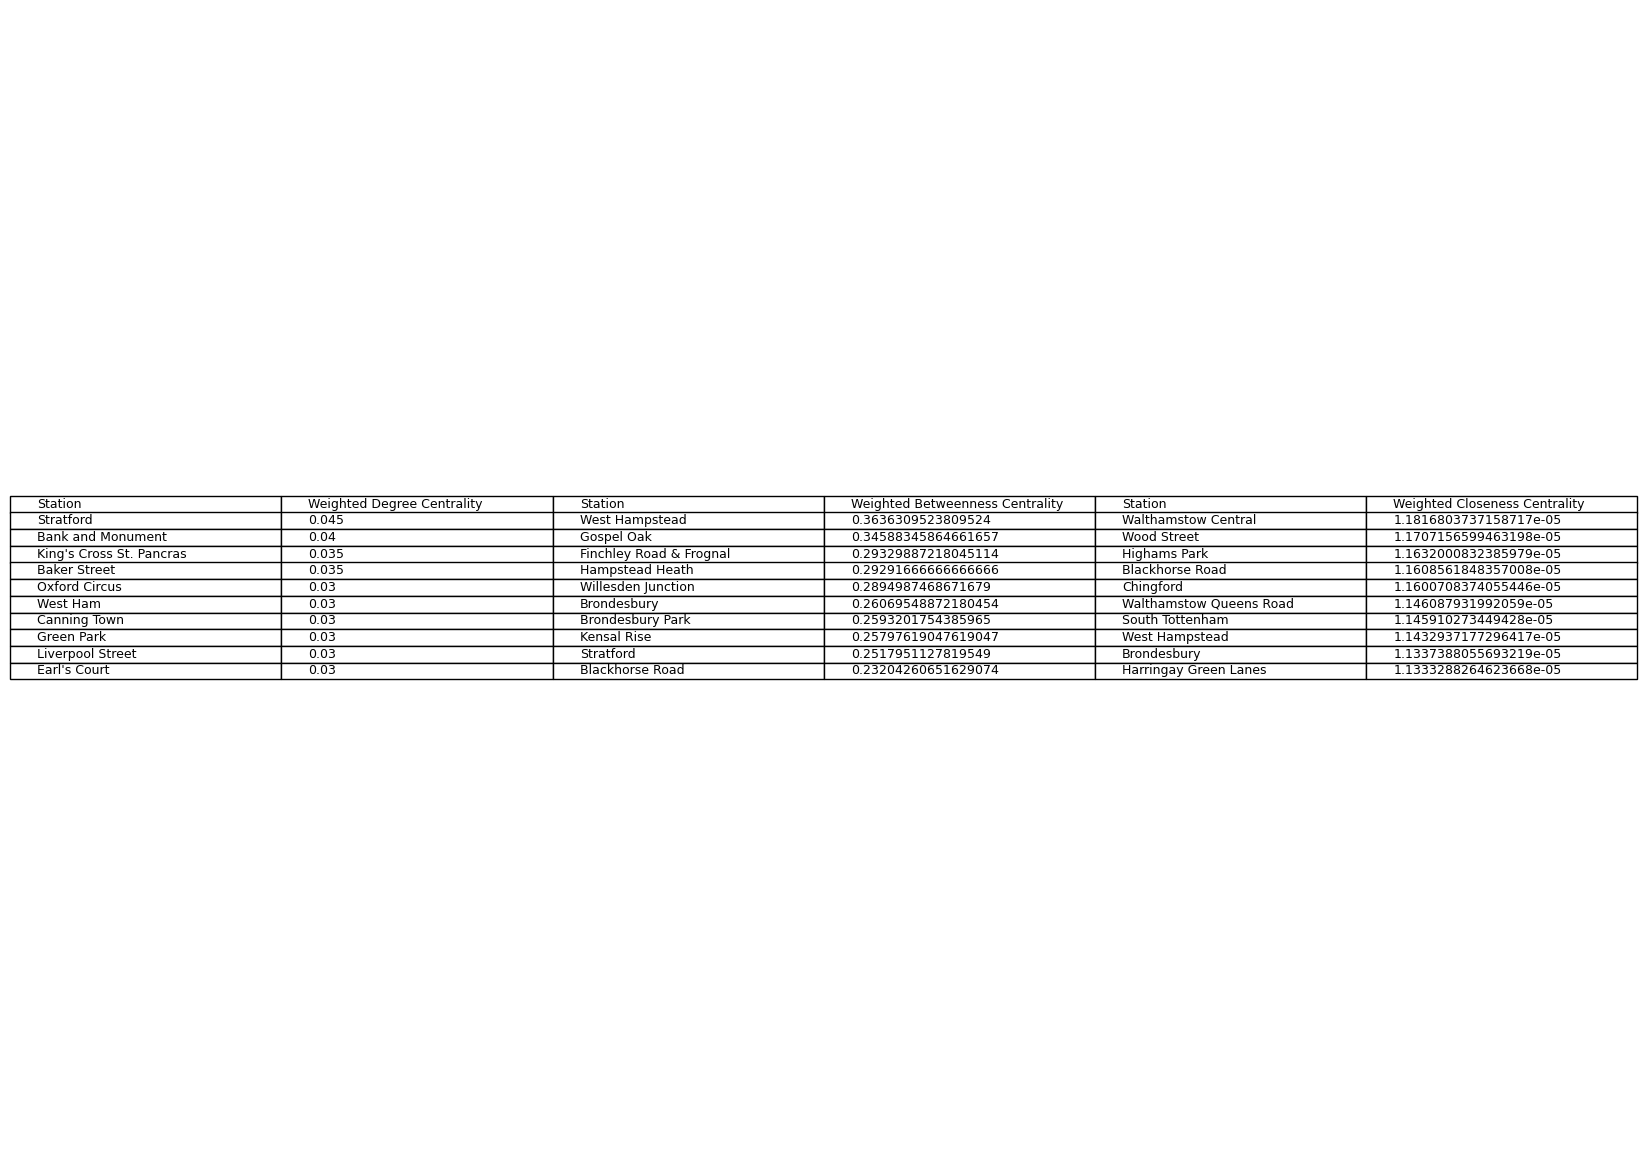

In [339]:
table4 = [weighted_centrality_results.columns.tolist()] + weighted_centrality_results.values.tolist()

fig, ax = plt.subplots(figsize=(21, 15))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=table4, colLabels=None, cellLoc='left', loc='center')
plt.savefig('img/w_table.png')

plt.show()

### II.2. Impacts Measures for weighted network

weighted LCC and EFF

Note that for the weighted LCC, we use `nx.strongly_connected_components()` instead of `nx.connected_components()` because we are dealing with a directed graph.

For the weighted EFF, we first computes the shortest path lengths between all pairs of nodes in G, taking into account the edge weights. It then uses a nested loop to compute the sum of the reciprocals of all shortest path lengths, and divides by n*(n-1) to get the global efficiency.

In [79]:
lcc_w = len(max(nx.strongly_connected_components(G_Di), key=len))

lcc_w

401

In [80]:
# Compute shortest path lengths, taking edge weights into account
shortest_paths = dict(nx.shortest_path_length(G_Di, weight='flows_Di'))
for node in shortest_paths:
    shortest_paths[node] = {k:v for k,v in shortest_paths[node].items() if v != 0}

# Compute global efficiency
n = len(G_Di.nodes)
eff_w = sum(1/(d_ij) for source in shortest_paths for d_ij in shortest_paths[source].values())/(n*(n-1))

eff_w

2.4695122360373563e-05

In [81]:
def eff_weighted(G):
    shortest_paths = dict(nx.shortest_path_length(G, weight='flows_Di'))
    for node in shortest_paths:
        shortest_paths[node] = {k:v for k,v in shortest_paths[node].items() if v != 0}
    n = len(G.nodes)
    eff_w = sum(1/(d_ij) for source in shortest_paths for d_ij in shortest_paths[source].values())/(n*(n-1))
    
    return eff_w

In [82]:
eff_weighted(G_Di)


2.4695122360373563e-05

##### APL average path length

In [83]:
avg_path_length = nx.average_shortest_path_length(G_Di, weight='flows_Di')

#### II.3. Node Removal

The 3 highest ranked nodes

In [84]:
# Define the centrality measures to be used.
centrality_measures = {
    'Degree': nx.degree_centrality(G_Di),
    'Betweenness': nx.betweenness_centrality(G_Di, weight='flows_Di'),
    'Closeness': nx.closeness_centrality(G_Di, distance='flows_Di')
}

# Define the removal strategies.
removal_strategies = ["non-sequential", "sequential"]

# Define the number of nodes to remove.
num_nodes_to_remove = 3

# Define a dataframe to save the results
results = pd.DataFrame()

# Iterate over the centrality measures and removal strategies.
for centrality in centrality_measures:
    for removal_strategy in removal_strategies:
        print(f"Centrality measure: {centrality_measure_name}")
        print(f"Removal strategy: {removal_strategy}")

        # Create a copy of the original graph.
        J = G_Di.copy()
        
        # Compute the centrality measure for each node.
        centrality_measures[centrality] = nx.degree_centrality(J) if centrality == 'Degree' \
        else nx.betweenness_centrality(J, weight='flows_Di') if centrality == 'Betweenness' \
        else nx.closeness_centrality(J, distance='flows_Di')

        # Sort the nodes by their centrality score.
        sorted_nodes = sorted(centrality_measures[centrality].items(), key=lambda x: x[1], reverse=True)

        # Remove nodes according to the selected removal strategy.
        if removal_strategy == "non-sequential":
            
            nodes_to_remove = [node[0] for node in sorted_nodes[:num_nodes_to_remove]]

            for node in nodes_to_remove:
                J.remove_node(node)

                # Compute the largest connected component and network efficiency.
                lcc = len(max(nx.strongly_connected_components(J), key=len)) #/ H.number_of_nodes()
                eff = eff_weighted(J)

                print(f"Removed node: {node}, w_LCC: {lcc:.0f}, w_EFF: {eff:.7f}")

                row = pd.DataFrame({'Removed_node': node,
                        'w_LCC': lcc, "w_EFF": eff}, index=[0])
                results = pd.concat([results, row], ignore_index = True)

        elif removal_strategy == "sequential":
            for i in range(num_nodes_to_remove):
                node_to_remove = sorted_nodes[i][0]

                # Compute the largest connected component and network efficiency before removing the node.
                lcc_before = len(max(nx.strongly_connected_components(J), key=len)) #/ H.number_of_nodes()
                eff_before = eff_weighted(J)

                # Remove the node and compute the largest connected component and network efficiency after removing the node.
                J.remove_node(node_to_remove)
                lcc_after = len(max(nx.strongly_connected_components(J), key=len)) #/ H.number_of_nodes()
                eff_after = eff_weighted(J)

                # Compute the change in the largest connected component and network efficiency.
                lcc_change = lcc_before - lcc_after
                eff_change = eff_before - eff_after

                print(f"Removed node: {node_to_remove}, LCC: {lcc_after:.0f}, EFF: {eff_after:.7f}")
                
                row = pd.DataFrame({'Removed_node': node_to_remove,
                        'w_LCC': lcc_after, "w_EFF": eff_after}, index=[0])
                results = pd.concat([results, row], ignore_index = True)

                # Recompute the centrality measure for each node.
                centrality_measures[centrality] = nx.degree_centrality(J) if centrality == 'Degree' \
                else nx.betweenness_centrality(J, weight='flows_Di') if centrality == 'Betweenness' \
                else nx.closeness_centrality(J, distance='flows_Di')

                # Sort the nodes by their centrality score.
                sorted_nodes = sorted(centrality_measures[centrality].items(), key=lambda x: x[1], reverse=True)

# Note: This code assumes that the London Tube network is stored in a file named "london_tube.edgelist" in the current directory. You may need to adjust the file name and path if your data


Centrality measure: closeness_centrality
Removal strategy: non-sequential
Removed node: Stratford, w_LCC: 379, w_EFF: 0.0000232
Removed node: Bank and Monument, w_LCC: 378, w_EFF: 0.0000230
Removed node: Baker Street, w_LCC: 377, w_EFF: 0.0000226
Centrality measure: closeness_centrality
Removal strategy: sequential
Removed node: Stratford, LCC: 379, EFF: 0.0000232
Removed node: Baker Street, LCC: 378, EFF: 0.0000228
Removed node: Oxford Circus, LCC: 376, EFF: 0.0000228
Centrality measure: closeness_centrality
Removal strategy: non-sequential
Removed node: West Hampstead, w_LCC: 400, w_EFF: 0.0000235
Removed node: Gospel Oak, w_LCC: 397, w_EFF: 0.0000231
Removed node: Finchley Road & Frognal, w_LCC: 397, w_EFF: 0.0000233
Centrality measure: closeness_centrality
Removal strategy: sequential
Removed node: West Hampstead, LCC: 400, EFF: 0.0000235
Removed node: Piccadilly Circus, LCC: 399, EFF: 0.0000233
Removed node: Oxford Circus, LCC: 398, EFF: 0.0000230
Centrality measure: closeness_cen

In [85]:
results

,Removed_node,w_LCC,w_EFF
0,Stratford,379,0.000023
1,Bank and Monument,378,0.000023
2,Baker Street,377,0.000023
3,Stratford,379,0.000023
4,Baker Street,378,0.000023
5,Oxford Circus,376,0.000023
6,West Hampstead,400,0.000024
7,Gospel Oak,397,0.000023
8,Finchley Road & Frognal,397,0.000023
9,West Hampstead,400,0.000024


In [86]:
w_results1_dc = results[:3].reset_index().rename(columns={'Removed_node': 'WDC_Removed_node_A', 'w_LCC': 'WDC_LCC_A', 'w_EFF': 'WDC_EFF_A'})
w_results1_bc = results[6:9].reset_index().rename(columns={'Removed_node': 'WBC_Removed_node_A', 'w_LCC': 'WBC_LCC_A', 'w_EFF': 'WBC_EFF_A'})
w_results1_cc = results[12:15].reset_index().rename(columns={'Removed_node': 'WCC_Removed_node_A', 'w_LCC': 'WCC_LCC_A', 'w_EFF': 'WCC_EFF_A'})

w_results1_final = pd.concat([w_results1_dc, w_results1_bc, w_results1_cc], axis=1)

w_results1_final = w_results1_final.drop(columns='index')

w_results1_final

,WDC_Removed_node_A,WDC_LCC_A,WDC_EFF_A,WBC_Removed_node_A,WBC_LCC_A,WBC_EFF_A,WCC_Removed_node_A,WCC_LCC_A,WCC_EFF_A
0,Stratford,379,0.000023,West Hampstead,400,0.000024,Walthamstow Central,397,0.000024
1,Bank and Monument,378,0.000023,Gospel Oak,397,0.000023,Wood Street,397,0.000024
2,Baker Street,377,0.000023,Finchley Road & Frognal,397,0.000023,Highams Park,397,0.000025


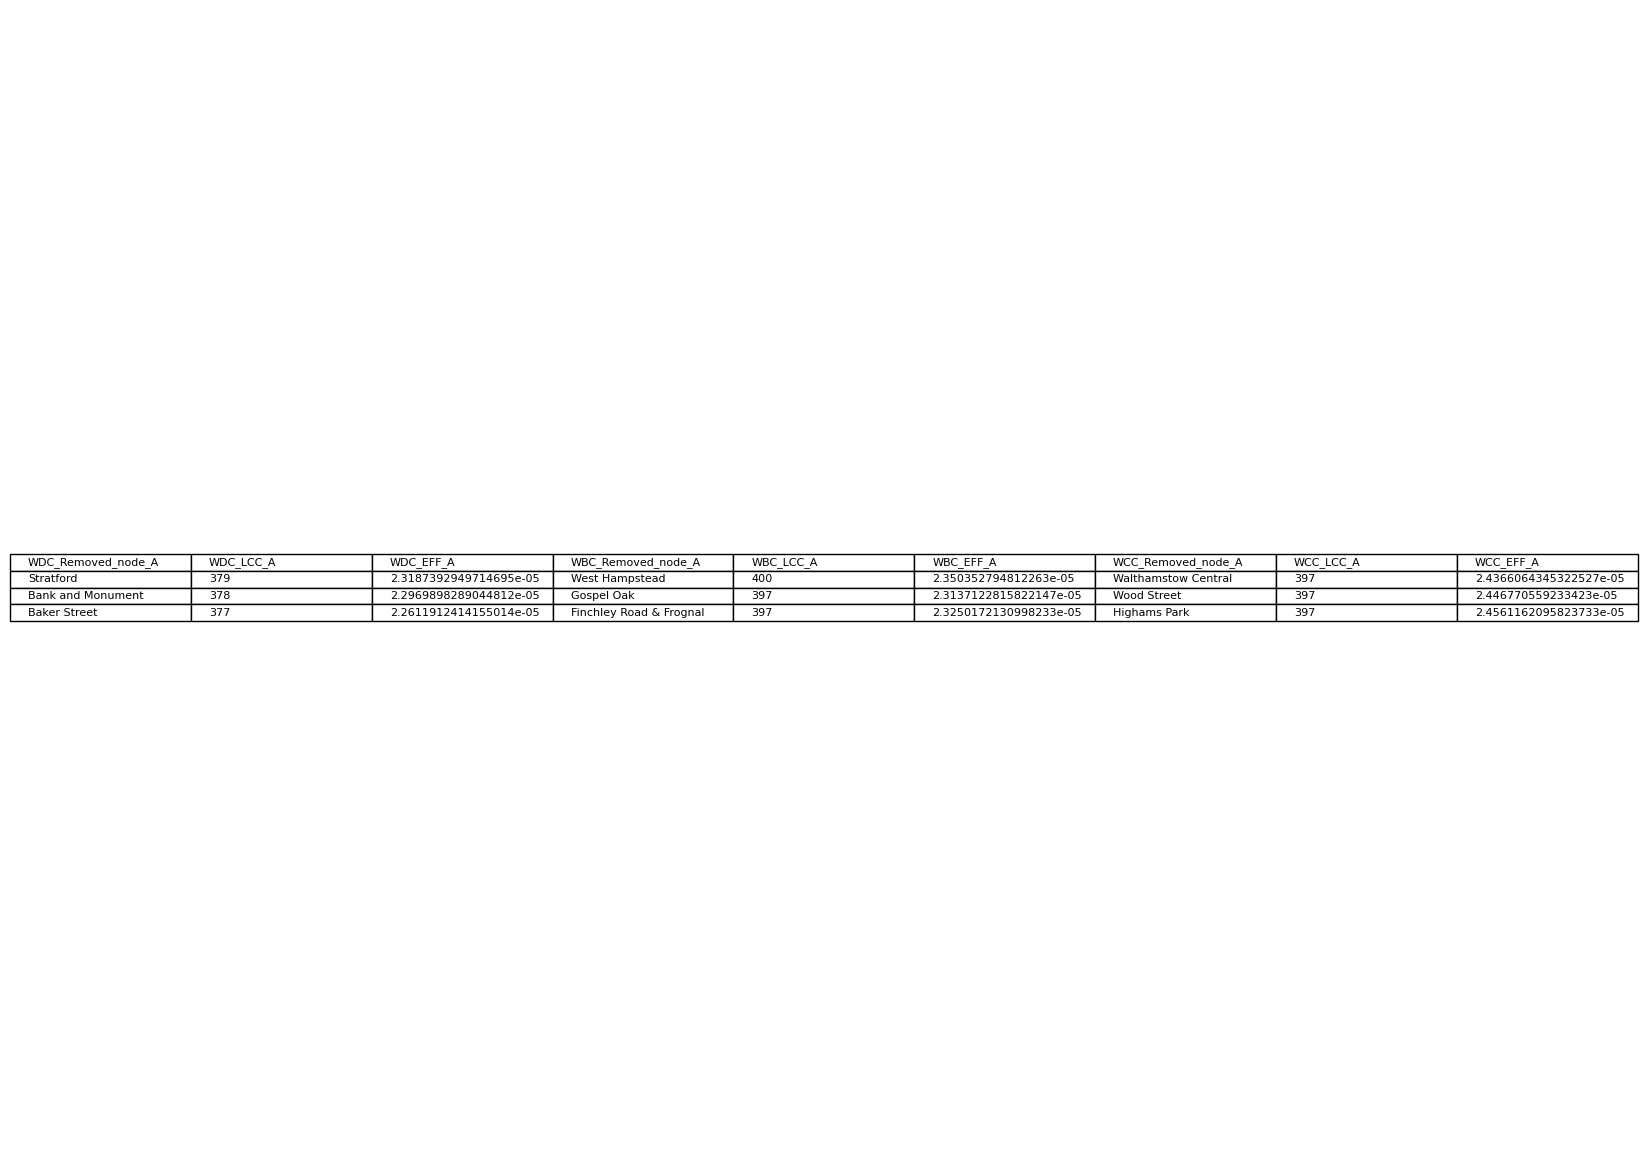

In [330]:
table5 = [w_results1_final.columns.tolist()] + w_results1_final.values.tolist()

fig, ax = plt.subplots(figsize=(21, 15))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=table5, colLabels=None, cellLoc='left', loc='center')
plt.savefig('img/nons_w.png')

plt.show()

In [87]:
w_results2_dc = results[3:6].reset_index().rename(columns={'Removed_node': 'WDC_Removed_node_B', 'w_LCC': 'WDC_LCC_B', 'w_EFF': 'WDC_EFF_B'})
w_results2_bc = results[9:12].reset_index().rename(columns={'Removed_node': 'WBC_Removed_node_B', 'w_LCC': 'WBC_LCC_B', 'w_EFF': 'WBC_EFF_B'})
w_results2_cc = results[15:18].reset_index().rename(columns={'Removed_node': 'WCC_Removed_node_B', 'w_LCC': 'WCC_LCC_B', 'w_EFF': 'WCC_EFF_B'})

w_results2_final = pd.concat([w_results2_dc, w_results2_bc, w_results2_cc], axis=1)

w_results2_final = w_results2_final.drop(columns='index')

w_results2_final

,WDC_Removed_node_B,WDC_LCC_B,WDC_EFF_B,WBC_Removed_node_B,WBC_LCC_B,WBC_EFF_B,WCC_Removed_node_B,WCC_LCC_B,WCC_EFF_B
0,Stratford,379,0.000023,West Hampstead,400,0.000024,Walthamstow Central,397,0.000024
1,Baker Street,378,0.000023,Piccadilly Circus,399,0.000023,Walthamstow Queens Road,396,0.000024
2,Oxford Circus,376,0.000023,Oxford Circus,398,0.000023,South Tottenham,395,0.000024


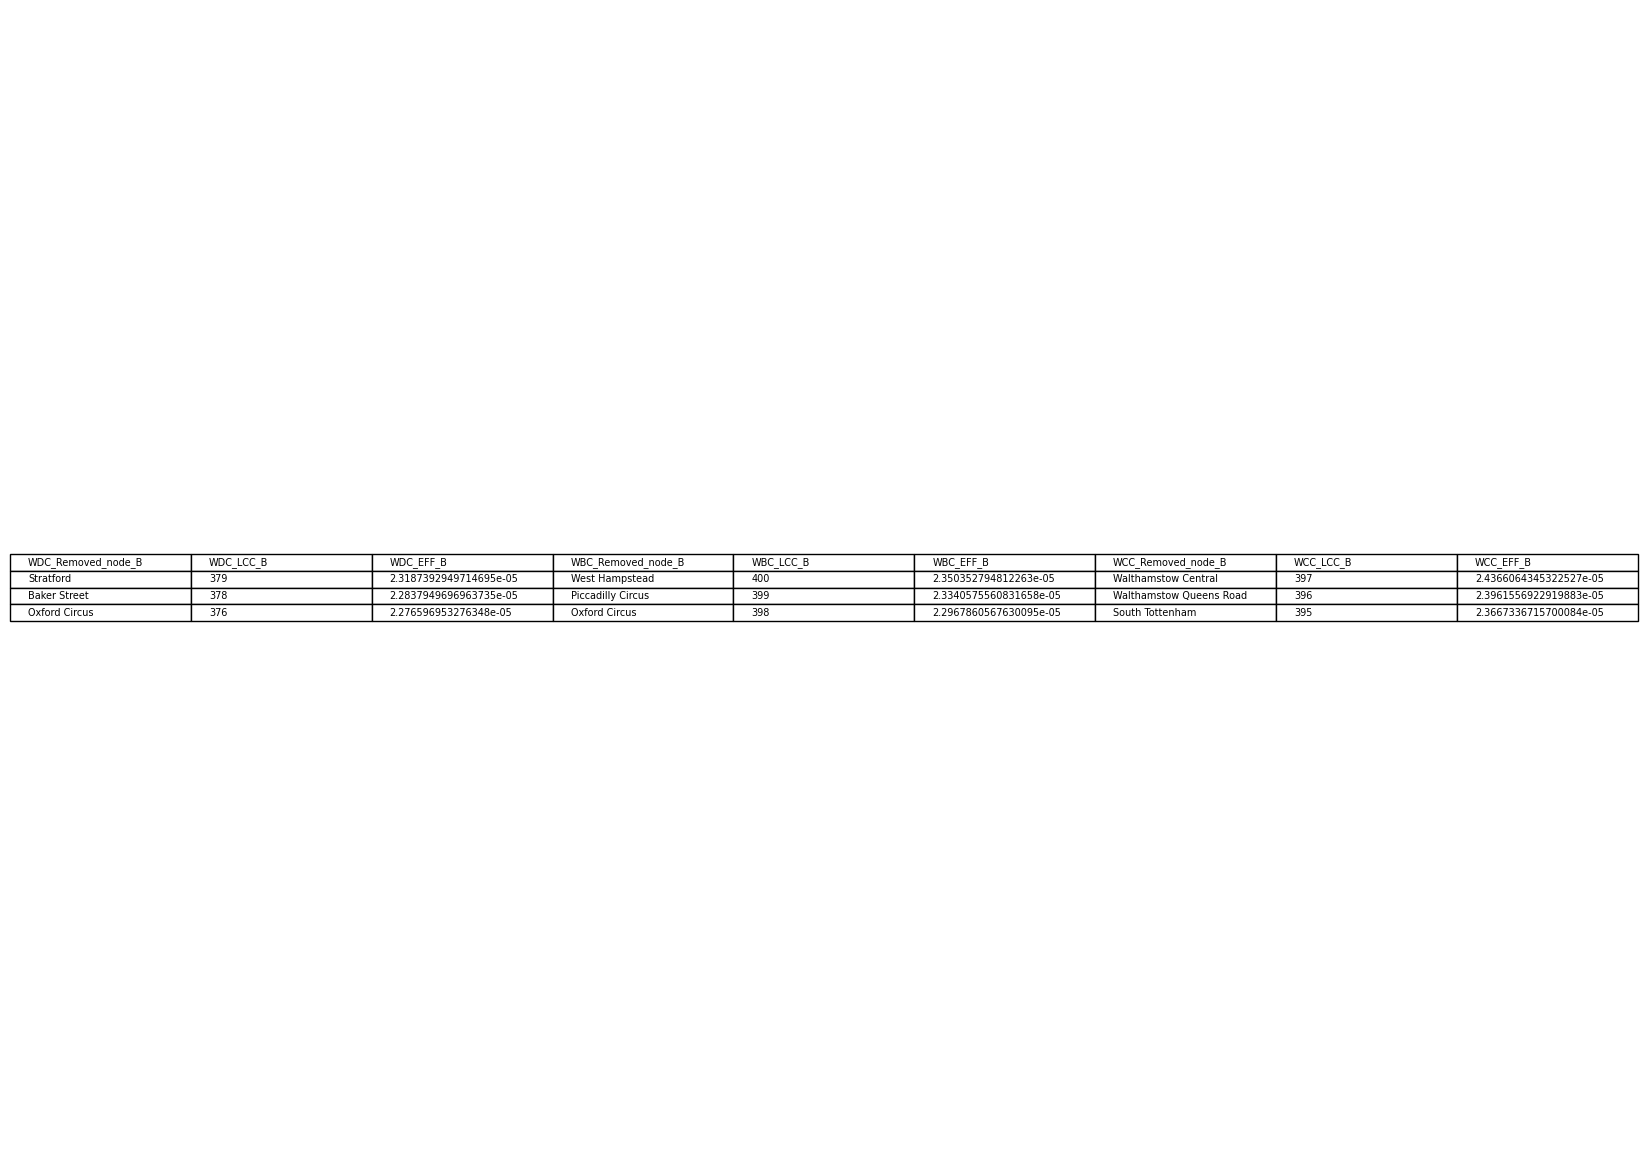

In [331]:
table6 = [w_results2_final.columns.tolist()] + w_results2_final.values.tolist()

fig, ax = plt.subplots(figsize=(21, 15))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=table6, colLabels=None, cellLoc='left', loc='center')
plt.savefig('img/squen_w.png')

plt.show()

## Part 2: Spatial Interaction Models

#### Create OD pairs with distance, population and jobs

In [88]:
df_OD = london_OD_new.rename(columns={'station_origin': 'Orig', 'station_destination': 'Dest'})

df_OD

,Orig,Dest,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [89]:
zero = df_OD.loc[df_OD['distance'] == 0]

zero

,Orig,Dest,flows,population,jobs,distance
4985,Blackfriars,Blackfriars,1,6781,10849,0.0
8847,Canary Wharf,Canary Wharf,0,14632,58772,0.0
9444,Cannon Street,Cannon Street,0,3874,4698,0.0
16611,Elephant & Castle,Elephant & Castle,0,9325,6427,0.0
17552,Euston,Euston,0,17796,16800,0.0
17807,Euston Square,Euston Square,0,4926,8093,0.0
18940,Finsbury Park,Finsbury Park,0,24735,6769,0.0
21752,Hackney Central,Hackney Central,0,3370,2440,0.0
21809,Hackney Downs,Hackney Downs,1,843,835,0.0
22242,Hammersmith,Hammersmith,0,11818,18250,0.0


In [90]:
df_OD2 = df_OD.copy()

df_OD2 = df_OD2[df_OD2['population'] != 0]

df_OD2 = df_OD2[df_OD2['jobs'] != 0]

df_OD2 = df_OD2[df_OD2['distance'] != 0]

df_OD2

,Orig,Dest,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [91]:
df_OD2[(df_OD2['Orig'].str.contains('Euston')) & (df_OD2['Dest'].str.contains('Baker'))]

,Orig,Dest,flows,population,jobs,distance
17489,Euston,Baker Street,7,17796,14973,3349.628017
17751,Euston Square,Baker Street,159,4926,14973,1446.779664


In [92]:
df_OD2[(df_OD2['Dest'].str.contains('Euston')) & (df_OD2['Orig'].str.contains('Baker'))]

,Orig,Dest,flows,population,jobs,distance
2154,Baker Street,Euston,1,7444,16800,3349.628017
2155,Baker Street,Euston Square,152,7444,8093,1446.779664


sort out the origin population, jobs

### III. Models and calibration

#### Models

In [106]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [93]:
Oi1_origpop = df_OD2[['Orig','population']]
Oi2_origjob = df_OD2[['Orig','jobs']]

In [94]:
destination = df_OD2['Dest']

In [95]:
Dj1_destpop = pd.merge(destination, Oi1_origpop, left_on='Dest', right_on='Orig')

Dj1_destpop = Dj1_destpop.drop(columns=['Orig']).rename(columns={'population':'Dj1_destpop'})

Dj1_destpop

,Dest,Dj1_destpop
0,Bank and Monument,29494
1,Bank and Monument,29494
2,Bank and Monument,29494
3,Bank and Monument,29494
4,Bank and Monument,29494
...,...,...
12756090,Brentwood,2174
12756091,Emerson Park,335
12756092,Emerson Park,335
12756093,Emerson Park,335


In [96]:
Dj2_destjob = pd.merge(destination, Oi2_origjob, left_on='Dest', right_on='Orig')

Dj2_destjob = Dj2_destjob.drop(columns=['Orig']).rename(columns={'jobs':'Dj2_destjob'})

Dj2_destjob

,Dest,Dj2_destjob
0,Bank and Monument,345
1,Bank and Monument,2202
2,Bank and Monument,7782
3,Bank and Monument,7932
4,Bank and Monument,444
...,...,...
12756090,Brentwood,55954
12756091,Emerson Park,2194
12756092,Emerson Park,1132
12756093,Emerson Park,2194


In [97]:
df_OD_new = df_OD2.copy()

In [98]:
df_OD_new['Oi1_origpop'] = Oi1_origpop['population']

df_OD_new['Oi2_origjob'] = Oi2_origjob['jobs']

df_OD_new['Dj1_destpop'] = Dj1_destpop['Dj1_destpop']

df_OD_new['Dj2_destjob'] = Dj2_destjob['Dj2_destjob']


In [99]:
df_OD_new

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,29494,345
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,29494,2202
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,29494,7782
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,29494,7932
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,29494,444
...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,29494,6145
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,29494,4250
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,29494,3759
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,29494,681


In [100]:
df_OD_new["log_Dist"] = np.log(df_OD_new['distance'] ) 

df_OD_new

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,log_Dist
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,29494,345,9.003504
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,29494,2202,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,29494,7782,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,29494,7932,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,29494,444,7.709274
...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,29494,6145,9.503144
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,29494,4250,9.071245
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,29494,3759,9.162905
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,29494,681,8.585832


In [101]:
#show the actual flows
ODmat = pd.pivot_table(df_OD_new, values ="flows", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)

# fill in 0 with NAN value
ODmat.fillna(0, inplace=True)
ODmat = ODmat.astype(int)

#show the data
ODmat

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,599
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1224
Acton Town,0,0,0,3,17,0,35,0,0,11,...,77,3,6,9,0,0,0,0,0,3745
Aldgate,0,0,0,0,0,0,0,0,0,17,...,0,0,4,8,0,0,0,0,0,2886
Aldgate East,0,0,2,0,0,0,0,0,0,20,...,24,0,0,12,0,1,0,1,0,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,5,47,0,0,0,0,22,...,2,0,1,0,0,0,0,0,0,4868
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530
Woodside Park,0,0,1,26,11,0,0,0,0,59,...,0,0,0,0,0,0,0,0,0,3093


In [102]:
df_OD_new["log_Oi1_origpop"] = np.log(df_OD_new['Oi1_origpop']) 
df_OD_new["log_Dj2_destjob"] = np.log(df_OD_new['Dj2_destjob']) 

df_OD_new

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,log_Dist,log_Oi1_origpop,log_Dj2_destjob
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,29494,345,9.003504,6.395262,5.843544
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,29494,2202,9.049012,6.395262,7.697121
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,29494,7782,8.236275,6.395262,8.959569
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,29494,7932,8.534348,6.395262,8.978660
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,29494,444,7.709274,6.395262,6.095825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,29494,6145,9.503144,8.973605,8.723394
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,29494,4250,9.071245,8.973605,8.354674
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,29494,3759,9.162905,8.973605,8.231908
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,29494,681,8.585832,8.973605,6.523562


In [105]:
#remove intraflows
df_OD_new1 = df_OD_new[df_OD_new["Orig"] != df_OD_new["Dest"]]

df_OD_new1

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,log_Dist,log_Oi1_origpop,log_Dj2_destjob
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,29494,345,9.003504,6.395262,5.843544
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,29494,2202,9.049012,6.395262,7.697121
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,29494,7782,8.236275,6.395262,8.959569
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,29494,7932,8.534348,6.395262,8.978660
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,29494,444,7.709274,6.395262,6.095825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,29494,6145,9.503144,8.973605,8.723394
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,29494,4250,9.071245,8.973605,8.354674
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,29494,3759,9.162905,8.973605,8.231908
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,29494,681,8.585832,8.973605,6.523562


In [111]:
#set out all the fomrulas
formula1 = "flows ~ np.log(Oi1_origpop) + np.log(Dj2_destjob) + np.log(distance) -1" #uncosim_pow
formula2 = "flows ~ Orig + np.log(Dj2_destjob) + np.log(distance) -1" #prodsim_pow
formula3 = "flows ~ np.log(Oi1_origpop) + Dest + np.log(distance) -1" #attrsim_pow
formula4 = "flows ~ Orig + Dest + np.log(distance) -1" #doublesim_pow
formula5 = "flows ~ np.log(Oi1_origpop) + np.log(Dj2_destjob) + distance -1" #uncosim_exp
formula6 = "flows ~ Orig + np.log(Dj2_destjob) + distance -1" #prodsim_exp
formula7 = "flows ~ np.log(Oi1_origpop) + Dest + distance -1" #attrsim_exp
formula8 = "flows ~ Orig + Dest + distance -1" #doublesim_exp

#create a list of all the formulas
formulas = [formula1, formula2, formula3, formula4, 
            formula5, formula6, formula7, formula8]

#list the models name
models = ["uncosim_pow", "prodsim_pow", "attrsim_pow", "doublesim_pow",
         "uncosim_exp", "prodsim_exp", "attrsim_exp", "doublesim_exp"]

#create a set of tuples to store whether a paramater
#will be in the model or not
model_params = [(True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True),
               (True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True)]

#create an ampty dictionary to store the results
results = {"Model":models,
          "R2": [],
          "RMSE": [],
          "Alpha":[],
          "Gamma":[],
          "Beta":[]}

#loop over each formula
for i, formula in enumerate(formulas):
    
    #run the specified model
    sim = smf.glm(formula = formula, 
                 data = df_OD_new1,
                 family = sm.families.Poisson()).fit()
    #clauclate the estimates
    df_OD_new1[models[i]] = sim.mu
    
    #if the alpha paramater is true
    if model_params[i][0] == True:
        
        #if there are three params then it will be 
        #in the third position
        if sum(model_params[i]) == 3:
            
            results["Alpha"].append(sim.params[-3])
            
        #otherwise it will be in the second paramater
        else:
            results["Alpha"].append(sim.params[-2])
            
    #if not then just append nan
    else:
        results["Alpha"].append(np.nan) 
    
    #if the gamma paramater is True
    #then it will always be the second paramater
    if model_params[i][1] == True:
        results["Gamma"].append(sim.params[-2])
    #otherwise add nan
    else:
        results["Gamma"].append(np.nan)
    
    #add the beta to the results (always will be there)
    results["Beta"].append(sim.params[-1])
        
    #add the metrics to the results dictionary
    results["R2"].append(CalcRSqaured(df_OD_new1["flows"],df_OD_new1[models[i]]))
    results["RMSE"].append(CalcRMSE(df_OD_new1["flows"],df_OD_new1[models[i]]))

#create a dataframe from the results
results = pd.DataFrame(results)
#print the results
results

,Model,R2,RMSE,Alpha,Gamma,Beta
0,uncosim_pow,0.097661,124.953,0.906641,0.118170,-0.589040
1,prodsim_pow,0.088772,126.574,NaN,0.008928,-0.954543
2,attrsim_pow,0.349942,106.012,0.745118,NaN,-0.635148
3,doublesim_pow,0.407697,101.334,NaN,NaN,-0.909632
4,uncosim_exp,0.126052,123.123,0.612353,-0.043095,-0.000135
5,prodsim_exp,0.138402,122.043,NaN,0.011554,-0.000150
6,attrsim_exp,0.399960,102.168,0.714555,NaN,-0.000100
7,doublesim_exp,0.497890,93.397,NaN,NaN,-0.000154


chossing doubly constrained model: origion(population) and destination(jobs) are fixed, and its exponential distance decay function has the highest $R^2$ and $RMSE$.

#### calibration

In [121]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(df_OD_new1.groupby(["Orig"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
df_OD_new1 = df_OD_new1.merge(O_i, on = "Orig", how = "left" )

D_j = pd.DataFrame(df_OD_new1.groupby(["Dest"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
df_OD_new1 = df_OD_new1.merge(D_j, on = "Dest", how = "left" )


df_OD_new1

,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,...,uncosim_pow,prodsim_pow,attrsim_pow,doublesim_pow,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,29494,345,...,3.271701,7.419385,53.077519,54.840694,13.014290,11.266112,71.498147,76.846663,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,29494,2202,...,3.965137,7.222531,2.813846,2.061926,11.416191,10.875871,3.261237,2.677506,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,29494,7782,...,7.429496,15.867424,3.587552,2.697948,20.493626,22.417082,4.564299,3.665771,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,29494,7932,...,6.247222,11.940248,69.639350,76.517784,17.153678,18.426730,92.987722,111.884860,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,29494,444,...,7.224481,25.578342,33.386510,45.398702,28.571465,27.336455,35.802014,47.768459,599,15428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,29494,6145,...,35.479129,134.362866,81.601879,256.673280,27.356922,110.051194,71.055176,185.497591,7892,3342
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,29494,4250,...,43.806352,202.252667,33.088410,152.447409,52.442083,221.458898,41.036398,176.151791,7892,5487
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,29494,3759,...,40.906153,185.106040,6.917988,19.538537,47.095861,195.155204,9.675577,26.589485,7892,400
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,29494,681,...,46.961356,316.245060,34.143705,115.297649,89.172754,357.789105,38.408213,131.895731,7892,893


In [133]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [123]:
df_OD_new2 = df_OD_new1.copy()

In [127]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'flows ~ Dest + Orig + log_Dist-1'
#run a doubly constrained sim
doubSim = smf.glm(formula = dbl_form, data=df_OD_new2, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7074e+05
Date:                Tue, 02 May 2023   Deviance:                   1.7693e+06
Time:                        02:57:32   Pearson chi2:                 2.47e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
De

In [132]:
#get the estimates
df_OD_new2["doubsimfitted"] = np.round(doubSim.mu)
#here's the matrix
ODmat1 = pd.pivot_table(df_OD_new2,values='doubsimfitted',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat1

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,600.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,1224.0
Acton Town,0,0,0,15,15,0,11,1,0,17,...,30,3,5,12,0,2,0,2,0,3747.0
Aldgate,0,0,2,0,42,0,0,0,0,19,...,7,0,2,2,0,1,0,1,0,2873.0
Aldgate East,0,0,2,49,0,0,1,0,0,21,...,8,1,3,2,0,1,0,1,0,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,7,31,33,0,0,0,0,29,...,29,0,10,0,0,0,0,0,0,4862.0
Woodgrange Park,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530.0
Woodside Park,0,0,5,18,17,0,3,0,0,22,...,21,0,6,0,0,0,0,0,0,3093.0


In [130]:
# Run a doubly constrained SIM with a negative exponential cost function.
doubsim_form = "flows ~ Orig + Dest + distance -1"
doubsim1 = smf.glm(formula=doubsim_form, data = df_OD_new2, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Tue, 02 May 2023   Deviance:                   1.5299e+06
Time:                        02:59:16   Pearson chi2:                 2.02e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Or

In [134]:
# Use the beta we got from the inverse power model
beta = -doubSim.params[-1]
# Get the balancing factors.
df_OD_new2 = balance_doubly_constrained(df_OD_new2,'Orig','Dest','O_i','D_j','distance',-beta,'power')

# Now predict the model again using the new Ai and Dj fields.
df_OD_new2['SIM_double_pow'] = np.round(df_OD_new2['O_i'] * df_OD_new2['Ai_new'] * df_OD_new2['D_j'] * df_OD_new2['Bj_new'] * 
                                   np.exp(np.log(df_OD_new2['distance'])*-beta))
# Check out the matrix
ODmat2 = pd.pivot_table(df_OD_new2,values='SIM_double_pow',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat2

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22


Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,600.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,1224.0
Acton Town,0,0,0,15,15,0,11,1,0,17,...,30,3,5,12,0,2,0,2,0,3747.0
Aldgate,0,0,2,0,42,0,0,0,0,19,...,7,0,2,2,0,1,0,1,0,2873.0
Aldgate East,0,0,2,49,0,0,1,0,0,21,...,8,1,3,2,0,1,0,1,0,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,7,31,33,0,0,0,0,29,...,29,0,10,0,0,0,0,0,0,4862.0
Woodgrange Park,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530.0
Woodside Park,0,0,5,18,17,0,3,0,0,22,...,21,0,6,0,0,0,0,0,0,3093.0


In [138]:
# Use the beta we got from the inverse power model
beta = -doubsim1.params[-1]

# Get the balancing factors. NB Setting of new field names for Ai and Bj.
df_OD_new2 = balance_doubly_constrained(df_OD_new2,'Orig','Dest','O_i','D_j','distance',-beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
df_OD_new2['SIM_double_exp'] = np.round(df_OD_new2['O_i'] * df_OD_new2['Ai_exp'] * df_OD_new2['D_j'] * df_OD_new2['Bj_exp'] * 
                                   np.exp(df_OD_new2['distance']*-beta))

# Check out the matrix
ODmat3 = pd.pivot_table(df_OD_new2,values='SIM_double_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat3

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23


Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,603.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1221.0
Acton Town,0,0,0,11,10,0,17,0,0,12,...,40,4,2,19,0,0,0,1,0,3752.0
Aldgate,0,0,1,0,32,0,0,0,0,23,...,7,0,3,2,0,1,0,1,0,2883.0
Aldgate East,0,0,2,38,0,0,0,0,0,24,...,7,1,3,2,0,1,0,1,0,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,38,44,0,0,0,0,25,...,7,0,7,0,0,0,0,0,0,4862.0
Woodgrange Park,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,2,17,15,0,0,0,0,25,...,10,0,4,0,0,0,0,0,0,3093.0


In [139]:
ODmat

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,599
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1224
Acton Town,0,0,0,3,17,0,35,0,0,11,...,77,3,6,9,0,0,0,0,0,3745
Aldgate,0,0,0,0,0,0,0,0,0,17,...,0,0,4,8,0,0,0,0,0,2886
Aldgate East,0,0,2,0,0,0,0,0,0,20,...,24,0,0,12,0,1,0,1,0,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,5,47,0,0,0,0,22,...,2,0,1,0,0,0,0,0,0,4868
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530
Woodside Park,0,0,1,26,11,0,0,0,0,59,...,0,0,0,0,0,0,0,0,0,3093


In [142]:
#use the beta in doubly constrained model
results[7:8]

,Model,R2,RMSE,Alpha,Gamma,Beta
7,doublesim_exp,0.49789,93.397,NaN,NaN,-0.000154


## IV. Scenarios

### IV.1. Scenario A

Job decresed 50% at 'Canary Wharf': destination's job decreased

number of commuters remain the same: origion's population is the same

consider the Origin Constrained Model

In [187]:
#calibrated parameter
results[5:6]

,Model,R2,RMSE,Alpha,Gamma,Beta
5,prodsim_exp,0.138402,122.043,NaN,0.011554,-0.00015


In [179]:
df_OD_new3 = df_OD_new1.copy()

In [180]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = "flows ~ Orig + np.log(Dj2_destjob) + distance -1"  #prodsim_exp
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=df_OD_new3, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6897e+06
Date:                Tue, 02 May 2023   Deviance:                   3.2071e+06
Time:                        03:33:48   Pearson chi2:                 7.12e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Orig[A

In [239]:
alpha_i = prodSim.params[0:-2]
gamma_a = prodSim.params[-2]
beta_a = -prodSim.params[-1]

In [182]:
alpha_i

Orig[Abbey Road]          3.571418
Orig[Acton Central]       4.532017
Orig[Acton Town]          4.576432
Orig[Aldgate]             3.851986
Orig[Aldgate East]        3.912646
                            ...   
Orig[Wood Street]         4.967064
Orig[Woodford]            5.569941
Orig[Woodgrange Park]     4.498497
Orig[Woodside Park]       5.252496
Orig[Woolwich Arsenal]    6.606150
Length: 398, dtype: float64

In [240]:
gamma_a

0.011553929921737238

In [241]:
beta_a

0.00014968094579214996

In [185]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(Orig)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
df_OD_new3 = df_OD_new3.merge(coefs, left_on="Orig", right_on="coef", how = "left")
df_OD_new3.drop(columns = ["coef"], inplace = True)
#check this has worked
df_OD_new3.head()

/var/folders/hn/dld6mz9d23s__7vwypkk2m180000gn/T/ipykernel_23063/2708451668.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,...,prodsim_pow,attrsim_pow,doublesim_pow,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,29494,345,...,7.419385,53.077519,54.840694,13.014290,11.266112,71.498147,76.846663,599,78549,3.571418
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,29494,2202,...,7.222531,2.813846,2.061926,11.416191,10.875871,3.261237,2.677506,599,442,3.571418
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,29494,7782,...,15.867424,3.587552,2.697948,20.493626,22.417082,4.564299,3.665771,599,665,3.571418
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,29494,7932,...,11.940248,69.639350,76.517784,17.153678,18.426730,92.987722,111.884860,599,58772,3.571418
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,29494,444,...,25.578342,33.386510,45.398702,28.571465,27.336455,35.802014,47.768459,599,15428,3.571418


In [242]:
df_OD_new3["prodsimest1"] = np.exp(df_OD_new3["alpha_i"]+gamma_a*df_OD_new3["log_Dj2_destjob"] 
                                 - beta_a*df_OD_new3["distance"])

# round the estimates
df_OD_new3["prodsimest1"] = round(df_OD_new3["prodsimest1"],0)
# Check out the matrix
ODmat4 = pd.pivot_table(df_OD_new3,values='prodsimest1',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat4

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,597.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,1223.0
Acton Town,0,0,0,9,8,0,50,0,0,10,...,10,13,3,41,0,1,0,2,0,3746.0
Aldgate,0,0,4,0,42,0,0,0,0,31,...,3,0,8,8,0,5,0,4,0,2884.0
Aldgate East,0,0,4,44,0,0,2,0,0,31,...,3,4,8,8,0,6,0,4,0,3176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,3,27,33,0,0,0,0,20,...,2,0,10,0,0,0,0,0,0,4867.0
Woodgrange Park,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,4,15,15,0,2,0,0,24,...,3,0,8,0,0,0,0,0,0,3085.0


In [188]:
# change the destinatio jobs

df_OD_new3['Dj3_destjobScenario'] = df_OD_new3['Dj2_destjob']

df_OD_new3['Dj3_destjobScenario'][df_OD_new3['Dest']=='Canary Wharf'] *= 0.5

df_OD_new3[df_OD_new3['Dest']=='Canary Wharf']

/var/folders/hn/dld6mz9d23s__7vwypkk2m180000gn/T/ipykernel_23063/2681448583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OD_new3['Dj3_destjobScenario'][df_OD_new3['Dest']=='Canary Wharf'] *= 0.5


,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,...,doublesim_pow,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j,alpha_i,prodsimest1,Dj3_destjobScenario
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,29494,7932,...,76.517784,17.153678,18.426730,92.987722,111.884860,599,58772,3.571418,18.0,3966.0
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,3745,58772,29494,2063,...,89.372230,7.060952,5.009787,74.936615,43.832546,3745,58772,4.576432,5.0,1031.5
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,2886,58772,29494,4698,...,73.075723,37.638010,19.435568,246.845063,106.955163,2886,58772,3.851986,19.0,2349.0
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,3172,58772,29494,893,...,105.382861,52.010054,25.118034,304.720352,145.832810,3172,58772,3.912646,25.0,446.5
817,All Saints,Canary Wharf,67,740,58772,1340.088733,740,58772,29494,1882,...,238.875752,34.455274,30.120697,157.084410,185.900502,740,58772,3.518681,30.0,941.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60534,Wood Green,Canary Wharf,64,6667,58772,16849.246595,6667,58772,29494,2167,...,195.954303,16.199290,20.448946,161.152321,144.618973,6667,58772,5.451196,20.0,1083.5
60777,Wood Lane,Canary Wharf,0,1088,58772,17092.091760,1088,58772,29494,800,...,25.721108,5.392560,2.175491,43.068366,15.598552,1088,58772,3.258381,2.0,400.0
61001,Woodford,Canary Wharf,192,4868,58772,13963.787075,4868,58772,29494,845,...,240.190912,20.546680,35.082210,171.591812,347.196616,4868,58772,5.569941,35.0,422.5
61233,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,3093,58772,29494,5966,...,97.548058,4.605148,7.437926,53.776756,54.065669,3093,58772,5.252496,7.0,2983.0


In [342]:
df_OD_new3["prodsimest2"] = np.exp(df_OD_new3["alpha_i"]+gamma_a*np.log(df_OD_new3["Dj3_destjobScenario"]) - beta_a*df_OD_new3["distance"])

df_OD_new3["prodsimest2"] = round(df_OD_new3["prodsimest2"],0)
#now we can convert the pivot table into a matrix
ODmat5 = pd.pivot_table(df_OD_new3,values='prodsimest2',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat5

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,597.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,1223.0
Acton Town,0,0,0,9,8,0,50,0,0,10,...,10,13,3,41,0,1,0,2,0,3746.0
Aldgate,0,0,4,0,42,0,0,0,0,31,...,3,0,8,8,0,5,0,4,0,2884.0
Aldgate East,0,0,4,44,0,0,2,0,0,31,...,3,4,8,8,0,6,0,4,0,3176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,3,27,33,0,0,0,0,20,...,2,0,10,0,0,0,0,0,0,4867.0
Woodgrange Park,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,4,15,15,0,2,0,0,24,...,3,0,8,0,0,0,0,0,0,3085.0


In [343]:
ODmat5

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,597.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,1223.0
Acton Town,0,0,0,9,8,0,50,0,0,10,...,10,13,3,41,0,1,0,2,0,3746.0
Aldgate,0,0,4,0,42,0,0,0,0,31,...,3,0,8,8,0,5,0,4,0,2884.0
Aldgate East,0,0,4,44,0,0,2,0,0,31,...,3,4,8,8,0,6,0,4,0,3176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,3,27,33,0,0,0,0,20,...,2,0,10,0,0,0,0,0,0,4867.0
Woodgrange Park,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,4,15,15,0,2,0,0,24,...,3,0,8,0,0,0,0,0,0,3085.0


In [345]:
change_A = ODmat5 - ODmat4

change_A

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Acton Town,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Aldgate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Aldgate East,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Woodside Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [344]:
change_A.sum()

Dest
Abbey Road            0.0
Acton Central         0.0
Acton Town            0.0
Aldgate               0.0
Aldgate East          0.0
                    ...  
Woodford              0.0
Woodgrange Park       0.0
Woodside Park         0.0
Woolwich Arsenal      0.0
All                -142.0
Length: 399, dtype: float64

### IV.2 Scenario B

a significantly increase on transport cost on London tube

##### IV.2.1 population decreased 

Due to rising transport fee on tube, people may choose bus for commuting.

Assuming that population in 'Bank and Monument' decreased 10%

consider the Destination constrained Model

In [192]:
results[6:7]

,Model,R2,RMSE,Alpha,Gamma,Beta
6,attrsim_exp,0.39996,102.168,0.714555,NaN,-0.0001


In [261]:
df_OD_new4 = df_OD_new1.copy()

In [232]:
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = "flows ~ np.log(Oi1_origpop) + Dest + distance -1" #attrsim_exp
#run a destination constrained sim
attrSim = smf.glm(formula = attr_form, data=df_OD_new4, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1128e+06
Date:                Tue, 02 May 2023   Deviance:                   2.0533e+06
Time:                        04:08:30   Pearson chi2:                 3.37e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Dest[A

In [262]:
#create a coefficients dataframe from the attrSim model
#call the coefficients gamma_j
coefs = pd.DataFrame(attrSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"gamma_j", "index":"coef"}, inplace = True)

#replace the unnecessary DestCodeNew and [] in the
#coefficients column of the coefs DataFrame
to_repl = ["(Dest)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
    
#then once you have done this you can join them back into the dataframes
df_OD_new4 = df_OD_new4.merge(coefs, left_on="Dest", right_on="coef", how = "left")
df_OD_new4.drop(columns = ["coef"], inplace = True)
#check this has worked
df_OD_new4.head()

/var/folders/hn/dld6mz9d23s__7vwypkk2m180000gn/T/ipykernel_23063/399907766.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,...,prodsim_pow,attrsim_pow,doublesim_pow,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j,gamma_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,29494,345,...,7.419385,53.077519,54.840694,13.014290,11.266112,71.498147,76.846663,599,78549,0.510073
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,29494,2202,...,7.222531,2.813846,2.061926,11.416191,10.875871,3.261237,2.677506,599,442,-2.539772
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,29494,7782,...,15.867424,3.587552,2.697948,20.493626,22.417082,4.564299,3.665771,599,665,-2.675342
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,29494,7932,...,11.940248,69.639350,76.517784,17.153678,18.426730,92.987722,111.884860,599,58772,0.469485
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,29494,444,...,25.578342,33.386510,45.398702,28.571465,27.336455,35.802014,47.768459,599,15428,-0.769688


In [263]:
#extract alpha and beta from the
#attrSim model
gamma_j= attrSim.params[0:-2]
alpha_b = attrSim.params[-2]
beta_b = -attrSim.params[-1]

In [253]:
gamma_j

Dest[Abbey Road]         -3.191658
Dest[Acton Central]      -1.942181
Dest[Acton Town]         -2.335480
Dest[Aldgate]            -1.592641
Dest[Aldgate East]       -1.635392
                            ...   
Dest[Wood Street]        -2.379227
Dest[Woodford]           -3.024083
Dest[Woodgrange Park]    -2.138025
Dest[Woodside Park]      -2.882157
Dest[Woolwich Arsenal]   -0.100378
Length: 398, dtype: float64

In [246]:
alpha_b

0.7145549849299171

In [247]:
beta_b

9.963285715409476e-05

In [268]:
#create estimate for attrsimest2
#using the calculated gamma_j and alpha and beta values
#remember to log the new origin population
df_OD_new4["attrsimest1"] = np.exp(df_OD_new4["gamma_j"]+alpha_b*np.log(df_OD_new4["Oi1_origpop"]) - beta_b*df_OD_new4["distance"])

#round these to integer values
#as we don't want half a person
df_OD_new4["attrsimest1"] = round(df_OD_new4["attrsimest1"],0)

#now we can convert the pivot table into a matrix
#now we can convert the pivot table into a matrix
ODmat6 = pd.pivot_table(df_OD_new4,values='attrsimest1',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat6

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,622.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,564.0
Acton Town,0,0,0,13,13,0,13,1,0,14,...,31,3,3,12,0,1,0,1,0,3523.0
Aldgate,0,0,5,0,50,0,0,1,0,40,...,18,0,8,5,0,3,0,3,0,5800.0
Aldgate East,0,0,6,56,0,0,2,1,0,42,...,19,2,8,6,0,4,0,3,0,6288.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,18,20,0,0,0,0,14,...,6,0,4,0,0,0,0,0,0,2663.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,163.0
Woodside Park,0,0,2,11,11,0,1,0,0,14,...,8,0,3,0,0,0,0,0,0,1912.0


In [276]:
# change the origin population

df_OD_new4['Oi3_origpopScenario'] = df_OD_new4['Oi1_origpop']

df_OD_new4['Oi3_origpopScenario'][df_OD_new4['Orig']=='Bank and Monument'] *= 0.9

df_OD_new4['Oi3_origpopScenario'] = round(df_OD_new4['Oi3_origpopScenario'], 0)

df_OD_new4[df_OD_new4['Orig']=='Bank and Monument']

/var/folders/hn/dld6mz9d23s__7vwypkk2m180000gn/T/ipykernel_23063/612748317.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OD_new4['Oi3_origpopScenario'][df_OD_new4['Orig']=='Bank and Monument'] *= 0.9


,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,...,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j,gamma_j,attrsimest1,Oi3_origpopScenario,attrsimest2
2555,Bank and Monument,Abbey Road,0,29494,345,8131.525097,29494,345,29494,693,...,137.295279,109.822630,28.569318,11.632384,29494,345,-3.191658,29.0,26545.0,26.0
2556,Bank and Monument,Acton Town,6,29494,2202,15507.134576,29494,2202,29494,975,...,49.960719,36.555184,32.254514,15.737683,29494,2202,-2.335480,32.0,26545.0,30.0
2557,Bank and Monument,Aldgate,31,29494,7782,1436.917240,29494,7782,29494,2406,...,321.403804,303.476118,275.435562,301.773929,29494,7782,-1.592641,275.0,26545.0,255.0
2558,Bank and Monument,Aldgate East,250,29494,7932,1678.964428,29494,7932,29494,1878,...,314.405475,291.841394,257.620178,271.417919,29494,7932,-1.635392,258.0,26545.0,239.0
2559,Bank and Monument,All Saints,25,29494,444,5917.717591,29494,444,29494,5975,...,168.730122,156.823685,40.925456,19.270759,29494,444,-3.052807,41.0,26545.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,Bank and Monument,Wood Green,31,29494,2146,12261.084457,29494,2146,29494,1493,...,76.043114,59.717078,42.412821,28.565233,29494,2146,-2.385101,42.0,26545.0,39.0
2856,Bank and Monument,Wood Lane,1,29494,1578,11704.669332,29494,1578,29494,1668,...,81.587485,64.986750,30.313912,20.498176,29494,1578,-2.776382,30.0,26545.0,28.0
2857,Bank and Monument,Woodford,10,29494,706,16021.076710,29494,706,29494,1335,...,45.983335,33.971654,15.392036,6.003679,29494,706,-3.024083,15.0,26545.0,14.0
2858,Bank and Monument,Woodside Park,9,29494,745,16969.144750,29494,745,29494,3019,...,39.058603,29.756473,16.140261,8.992562,29494,745,-2.882157,16.0,26545.0,15.0


In [269]:
#create estimate for attrsimest2
#using the calculated gamma_j and alpha and beta values
#remember to log the new origin population
df_OD_new4["attrsimest2"] = np.exp(df_OD_new4["gamma_j"]+alpha_b*np.log(df_OD_new4["Oi3_origpopScenario"]) - beta_b*df_OD_new4["distance"])

#round these to integer values
#as we don't want half a person
df_OD_new4["attrsimest2"] = round(df_OD_new4["attrsimest2"],0)

#now we can convert the pivot table into a matrix
#now we can convert the pivot table into a matrix
ODmat7 = pd.pivot_table(df_OD_new4,values='attrsimest2',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat7

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,622.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,564.0
Acton Town,0,0,0,13,13,0,13,1,0,14,...,31,3,3,12,0,1,0,1,0,3523.0
Aldgate,0,0,5,0,50,0,0,1,0,40,...,18,0,8,5,0,3,0,3,0,5800.0
Aldgate East,0,0,6,56,0,0,2,1,0,42,...,19,2,8,6,0,4,0,3,0,6288.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,18,20,0,0,0,0,14,...,6,0,4,0,0,0,0,0,0,2663.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,163.0
Woodside Park,0,0,2,11,11,0,1,0,0,14,...,8,0,3,0,0,0,0,0,0,1912.0


In [346]:
ODmat7

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,600.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,767.0
Acton Town,0,0,0,11,11,0,60,1,0,13,...,14,18,5,47,0,2,0,4,0,4555.0
Aldgate,0,0,9,0,76,0,0,0,0,56,...,7,0,19,19,0,11,0,9,0,6002.0
Aldgate East,0,0,11,84,0,0,5,0,0,59,...,8,9,18,19,0,15,0,10,0,6587.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,16,20,0,0,0,0,11,...,1,0,7,0,0,0,0,0,0,2657.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,209.0
Woodside Park,0,0,3,10,10,0,2,0,0,14,...,2,0,6,0,0,0,0,0,0,1791.0


In [270]:
change_B1 = ODmat7 - ODmat6

change_B1

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Acton Town,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Aldgate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Aldgate East,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Woodside Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [350]:
change_B1.sum()

Dest
Abbey Road            -6.0
Acton Central          0.0
Acton Town            -4.0
Aldgate              -40.0
Aldgate East         -38.0
                     ...  
Woodford              -2.0
Woodgrange Park        0.0
Woodside Park         -2.0
Woolwich Arsenal     -48.0
All                -5336.0
Length: 399, dtype: float64

#### IV.B.2 both job and population decreased

Assuming that population decreased 5%, and job decreased 5%
consider the unconstrained Model

In [206]:
results[4:5]

,Model,R2,RMSE,Alpha,Gamma,Beta
4,uncosim_exp,0.126052,123.123,0.612353,-0.043095,-0.000135


In [207]:
df_OD_new5 = df_OD_new1.copy()

In [220]:
#create the formula
uncon_form = "flows ~ np.log(Oi1_origpop) + np.log(Dj2_destjob) + distance - 1" #uncosim_exp

#run the regression
uncosim = smf.glm(formula = uncon_form, 
                  data=df_OD_new5, 
                  family=sm.families.Poisson()).fit()

#extract the summary of the unconstrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61410
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9311e+06
Date:                Tue, 02 May 2023   Deviance:                   3.6901e+06
Time:                        04:02:20   Pearson chi2:                 1.25e+07
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
np.log(Oi1_origpop)     0.6124    

In [271]:
#first assign the parameter values from the model to the appropriate variables
alpha_b2 = uncosim.params[0]
gamma_b2 = uncosim.params[1]
beta_b2 = -uncosim.params[2]

In [272]:
alpha_b2

0.6123530664583811

In [273]:
gamma_b2

-0.04309522199572727

In [274]:
beta_b2

0.00013506460910252827

In [287]:

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
df_OD_new5["unconstrainedEst1"] = np.exp(alpha_b2*df_OD_new5["log_Oi1_origpop"] 
                                       + gamma_b2*df_OD_new5["log_Dj2_destjob"] 
                                       - beta_b2*df_OD_new5["distance"])

#round the numbers so that we don't get a half of a person
df_OD_new5["unconstrainedEst1"] = round(df_OD_new5["unconstrainedEst1"], 0)

#now we can convert the pivot table into a matrix
ODmat8 = pd.pivot_table(df_OD_new5,values='unconstrainedEst1',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat8


Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,600.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,767.0
Acton Town,0,0,0,11,11,0,60,1,0,13,...,14,18,5,47,0,2,0,4,0,4555.0
Aldgate,0,0,9,0,76,0,0,0,0,56,...,7,0,19,19,0,11,0,9,0,6002.0
Aldgate East,0,0,11,84,0,0,5,0,0,59,...,8,9,18,19,0,15,0,10,0,6587.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,16,20,0,0,0,0,11,...,1,0,7,0,0,0,0,0,0,2657.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,209.0
Woodside Park,0,0,3,10,10,0,2,0,0,14,...,2,0,6,0,0,0,0,0,0,1791.0


In [283]:
# change the origin pop and destination jobs


df_OD_new5['Oi4_origpopScenario'] = df_OD_new5['Oi1_origpop']

df_OD_new5['Oi4_origpopScenario'][df_OD_new5['Orig']=='Bank and Monument'] *= 0.95

df_OD_new5['Oi4_origpopScenario'] = round(df_OD_new5['Oi4_origpopScenario'], 0)


df_OD_new5['Dj4_destjobScenario'] = df_OD_new5['Dj2_destjob']

df_OD_new5['Dj4_destjobScenario'][df_OD_new5['Orig']=='Bank and Monument'] *= 0.95

df_OD_new5['Dj4_destjobScenario'] = round(df_OD_new5['Dj4_destjobScenario'], 0)


df_OD_new5[df_OD_new5['Orig']=='Bank and Monument']

/var/folders/hn/dld6mz9d23s__7vwypkk2m180000gn/T/ipykernel_23063/2180955720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OD_new5['Oi4_origpopScenario'][df_OD_new5['Orig']=='Bank and Monument'] *= 0.95
/var/folders/hn/dld6mz9d23s__7vwypkk2m180000gn/T/ipykernel_23063/2180955720.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OD_new5['Dj4_destjobScenario'][df_OD_new5['Orig']=='Bank and Monument'] *= 0.95


,Orig,Dest,flows,population,jobs,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,...,uncosim_exp,prodsim_exp,attrsim_exp,doublesim_exp,O_i,D_j,unconstrainedEst1,Oi4_origpopScenario,Dj4_destjobScenario,unconstrainedEst2
2555,Bank and Monument,Abbey Road,0,29494,345,8131.525097,29494,345,29494,693,...,137.295279,109.822630,28.569318,11.632384,29494,345,137.0,28019.0,658.0,133.0
2556,Bank and Monument,Acton Town,6,29494,2202,15507.134576,29494,2202,29494,975,...,49.960719,36.555184,32.254514,15.737683,29494,2202,50.0,28019.0,926.0,49.0
2557,Bank and Monument,Aldgate,31,29494,7782,1436.917240,29494,7782,29494,2406,...,321.403804,303.476118,275.435562,301.773929,29494,7782,321.0,28019.0,2286.0,312.0
2558,Bank and Monument,Aldgate East,250,29494,7932,1678.964428,29494,7932,29494,1878,...,314.405475,291.841394,257.620178,271.417919,29494,7932,314.0,28019.0,1784.0,305.0
2559,Bank and Monument,All Saints,25,29494,444,5917.717591,29494,444,29494,5975,...,168.730122,156.823685,40.925456,19.270759,29494,444,169.0,28019.0,5676.0,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,Bank and Monument,Wood Green,31,29494,2146,12261.084457,29494,2146,29494,1493,...,76.043114,59.717078,42.412821,28.565233,29494,2146,76.0,28019.0,1418.0,74.0
2856,Bank and Monument,Wood Lane,1,29494,1578,11704.669332,29494,1578,29494,1668,...,81.587485,64.986750,30.313912,20.498176,29494,1578,82.0,28019.0,1585.0,79.0
2857,Bank and Monument,Woodford,10,29494,706,16021.076710,29494,706,29494,1335,...,45.983335,33.971654,15.392036,6.003679,29494,706,46.0,28019.0,1268.0,45.0
2858,Bank and Monument,Woodside Park,9,29494,745,16969.144750,29494,745,29494,3019,...,39.058603,29.756473,16.140261,8.992562,29494,745,39.0,28019.0,2868.0,38.0


In [286]:

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
df_OD_new5["unconstrainedEst2"] = np.exp(alpha_b2*np.log(df_OD_new5['Oi4_origpopScenario']) 
                                       + gamma_b2*np.log(df_OD_new5['Dj4_destjobScenario']) 
                                       - beta_b2*df_OD_new5["distance"])

#round the numbers so that we don't get a half of a person
df_OD_new5["unconstrainedEst2"] = round(df_OD_new5["unconstrainedEst2"], 0)

#now we can convert the pivot table into a matrix
ODmat9 = pd.pivot_table(df_OD_new5,values='unconstrainedEst2',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

ODmat9


Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,600.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,767.0
Acton Town,0,0,0,11,11,0,60,1,0,13,...,14,18,5,47,0,2,0,4,0,4555.0
Aldgate,0,0,9,0,76,0,0,0,0,56,...,7,0,19,19,0,11,0,9,0,6002.0
Aldgate East,0,0,11,84,0,0,5,0,0,59,...,8,9,18,19,0,15,0,10,0,6587.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,16,20,0,0,0,0,11,...,1,0,7,0,0,0,0,0,0,2657.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,209.0
Woodside Park,0,0,3,10,10,0,2,0,0,14,...,2,0,6,0,0,0,0,0,0,1791.0


In [347]:
ODmat9

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,600.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,767.0
Acton Town,0,0,0,11,11,0,60,1,0,13,...,14,18,5,47,0,2,0,4,0,4555.0
Aldgate,0,0,9,0,76,0,0,0,0,56,...,7,0,19,19,0,11,0,9,0,6002.0
Aldgate East,0,0,11,84,0,0,5,0,0,59,...,8,9,18,19,0,15,0,10,0,6587.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,16,20,0,0,0,0,11,...,1,0,7,0,0,0,0,0,0,2657.0
Woodgrange Park,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,209.0
Woodside Park,0,0,3,10,10,0,2,0,0,14,...,2,0,6,0,0,0,0,0,0,1791.0


In [288]:
change_B2 = ODmat9 - ODmat8

change_B2

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Acton Town,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Aldgate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Aldgate East,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Woodside Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [351]:
change_B2.sum()

Dest
Abbey Road            -8.0
Acton Central          0.0
Acton Town            -2.0
Aldgate              -18.0
Aldgate East         -18.0
                     ...  
Woodford              -2.0
Woodgrange Park        0.0
Woodside Park         -2.0
Woolwich Arsenal      -4.0
All                -2012.0
Length: 399, dtype: float64